In [1]:
import numpy as np
import cv2
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
import numpy as np
import os
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("/home/ilya/ai/tf-models/research/object_detection")
from object_detection.utils import ops as utils_ops
sys.path

['',
 '/home/ilya/ai/tf-models/research',
 '/home/ilya/ai/tf-models/research/slim',
 '/home/ilya/ai/opencv-bin/lib/python3.6/site-packages',
 '/usr/lib64/python36.zip',
 '/usr/lib64/python3.6',
 '/usr/lib64/python3.6/lib-dynload',
 '/home/ilya/.local/lib64/python3.6/site-packages',
 '/usr/lib64/python3.6/site-packages',
 '/usr/lib64/python3.6/site-packages/IPython/extensions',
 '/home/ilya/.ipython',
 '/home/ilya/ai/tf-models/research/object_detection']

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

/home/ilya/ai/tf-models/research/object_detection/utils/visualization_utils.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib64/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib64/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/lib64/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/lib64/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/lib64/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/lib64/python3.6/site-pac

In [4]:
img = cv2.imread('/home/ilya/ai/kaggle/whales/input/train/8baaa687.jpg')

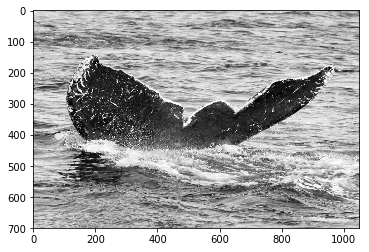

In [5]:
plt.imshow(img)

In [6]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

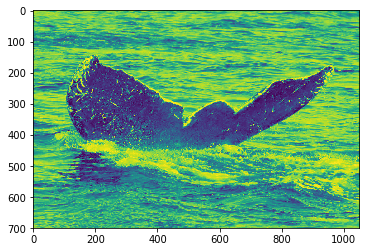

In [7]:
plt.imshow(gray)

In [8]:
print(img.shape)
print(gray.shape)
print(len(img.shape))

(700, 1050, 3)
(700, 1050)
3


In [9]:
def load_detection_graph(run=None):
    if run is None:
        modelfile='frozen_inference_graph.pb'
    else:
        modelfile='frozen_inference_graph-run%d.pb'%run
    path='/home/ilya/ai/kaggle/whales/input/mask_inference_graph/'+modelfile
    detection_graph = tf.Graph()
    with detection_graph.as_default():
      od_graph_def = tf.GraphDef()
      with tf.gfile.GFile(path, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
    return detection_graph

In [10]:
label_map = label_map_util.load_labelmap('/home/ilya/ai/kaggle/whales/input/label_map.pbtxt')
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=2, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [11]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [12]:
detection_graph=load_detection_graph()

In [17]:
def detect_edges(image):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    element = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))

    morphed = cv2.morphologyEx(gray, cv2.MORPH_OPEN, element) #Open and close to make appear contours
    morphed = cv2.morphologyEx(morphed, cv2.MORPH_CLOSE, element)

    ret, thresholded = cv2.threshold(morphed, 128, 255, cv2.THRESH_BINARY_INV)

    im2, contours, hierarchy = cv2.findContours(thresholded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(image, contours, -1, (0,255,0), 3)
    return image

In [18]:
def process_image(impath):
    imgorig=cv2.imread(impath)
    output_dict = run_inference_for_single_image(imgorig, detection_graph)
    instance_masks=output_dict.get('detection_masks')
    for m in instance_masks:
        img=cv2.bitwise_and(imgorig, imgorig, mask=m)
    
    img_edge=detect_edges(np.copy(img))
    return [imgorig, img, img_edge]

In [19]:
process_image('/home/ilya/ai/kaggle/whales/input/train/00a29f63.jpg')

[array([[[200, 200, 200],
         [200, 200, 200],
         [200, 200, 200],
         ...,
         [200, 200, 200],
         [200, 200, 200],
         [200, 200, 200]],
 
        [[200, 200, 200],
         [200, 200, 200],
         [200, 200, 200],
         ...,
         [200, 200, 200],
         [200, 200, 200],
         [200, 200, 200]],
 
        [[202, 202, 202],
         [202, 202, 202],
         [202, 202, 202],
         ...,
         [200, 200, 200],
         [200, 200, 200],
         [200, 200, 200]],
 
        ...,
 
        [[181, 178, 163],
         [183, 180, 165],
         [186, 183, 168],
         ...,
         [201, 193, 194],
         [191, 183, 184],
         [191, 183, 184]],
 
        [[171, 168, 153],
         [173, 170, 155],
         [177, 174, 159],
         ...,
         [194, 186, 187],
         [185, 177, 178],
         [185, 177, 178]],
 
        [[146, 143, 128],
         [149, 146, 131],
         [153, 150, 135],
         ...,
         [186, 178, 179],
  

In [ ]:
process_image('/home/ilya/ai/kaggle/whales/input/train/0c6eb67b.jpg')

In [ ]:
plt.imshow(img)

In [ ]:
def detect_fluke(file):
    img = cv2.imread(file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    flukes = whale_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in flukes:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    return img

In [20]:
from PIL import Image
from io import BytesIO
from IPython.display import HTML
import glob
import random
import base64

pd.set_option('display.max_colwidth', -1)

def image_base64(im):
    if isinstance(im, np.ndarray):
        im=Image.fromarray(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return '<img src="data:image/jpeg;base64,{img}">'.format(img=image_base64(im))


In [21]:
from os import listdir
import random
import pandas as pd


In [22]:
fpd = pd.DataFrame()
fpd['files']=random.sample(listdir('/home/ilya/ai/kaggle/whales/input/train/'), 10)
#fpd['flukes']=fpd.files.map(lambda file: process_image('/home/ilya/ai/kaggle/whales/input/train/'+file))
fpd['fimgs']=fpd.files.map(lambda file: process_image('/home/ilya/ai/kaggle/whales/input/train/'+file))


In [23]:
fpd['fimg']=fpd.fimgs.map(lambda imgs: imgs[0])
fpd['fimgm']=fpd.fimgs.map(lambda imgs: imgs[1])
fpd['fimge']=fpd.fimgs.map(lambda imgs: imgs[2])
#fpd['fimg']=fpd.flukes.map(lambda image: Image.fromarray(image))


In [24]:
fpd['bw']=fpd.fimg.map(lambda img: cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)[1])
#fpd['bw']=fpd.fimg.map(lambda img: cv2.threshold(img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1])
#fpd['gray']=fpd.fimg.map(lambda image: cv.cvtColor(np.array(image) , cv2.COLOR_BGR2GRAY))

In [25]:
#fpd['fimg']


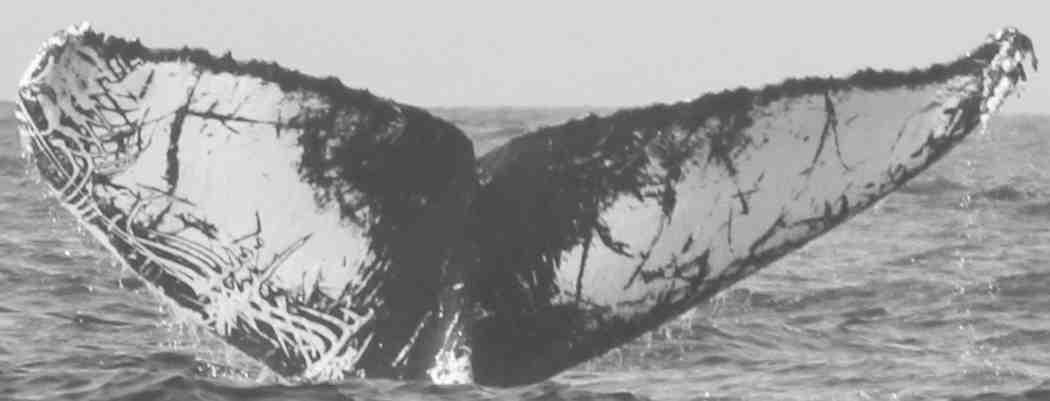
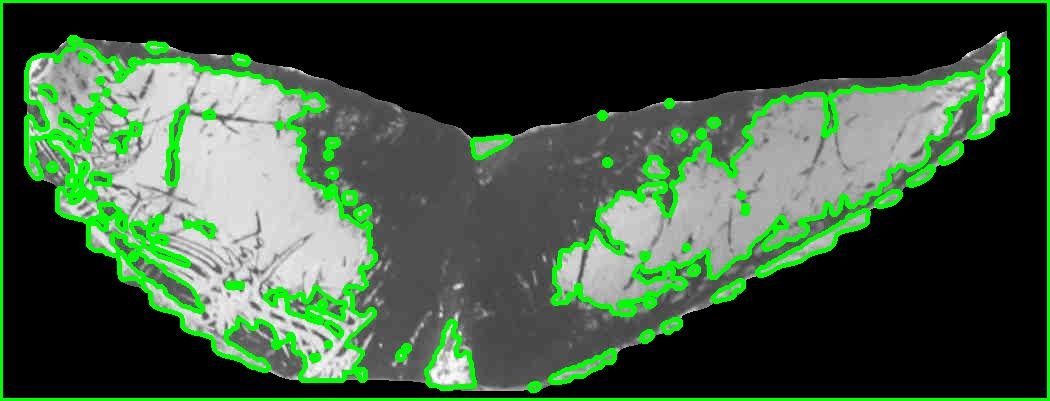
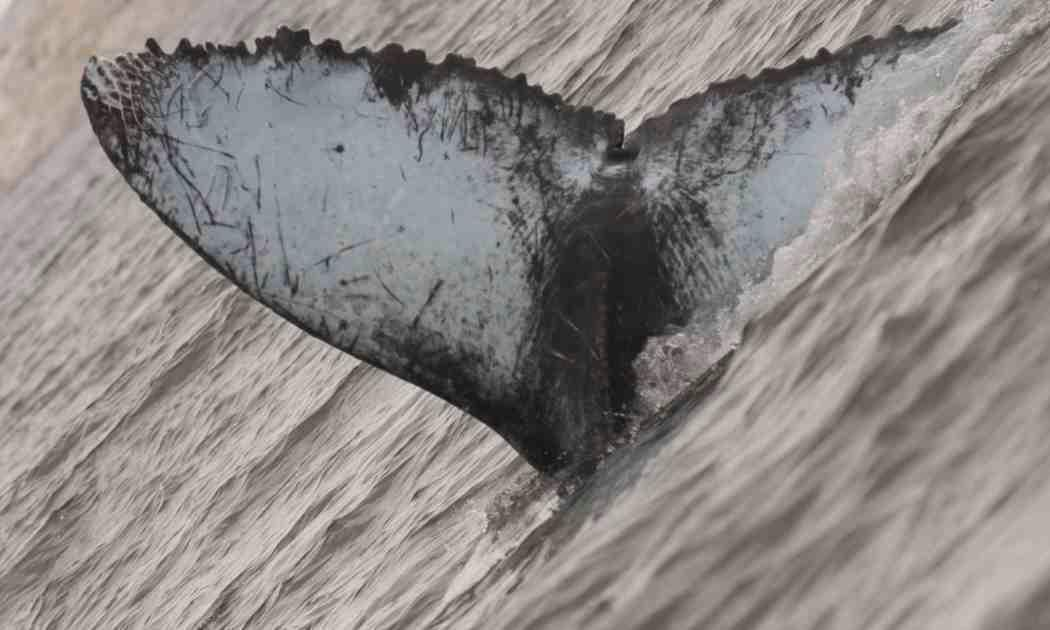
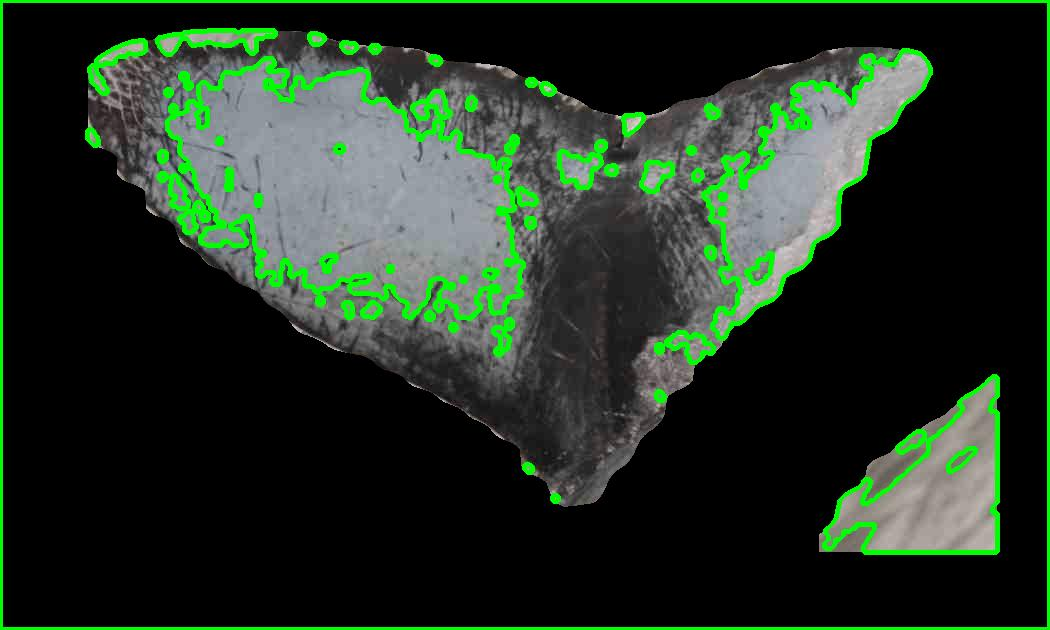
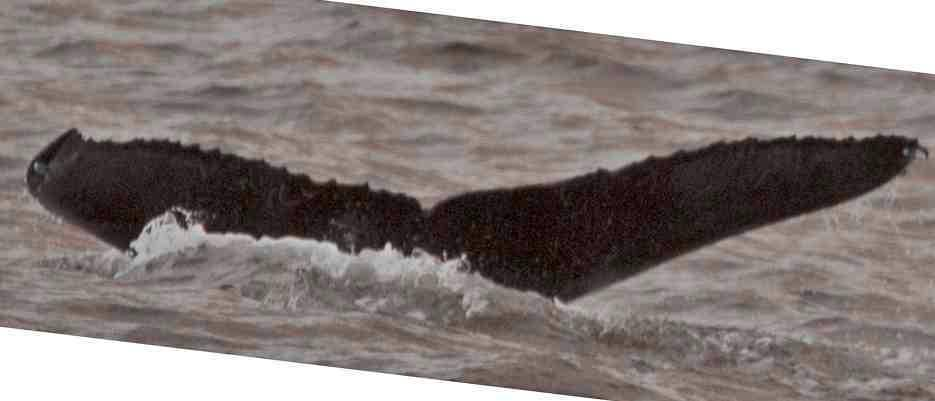
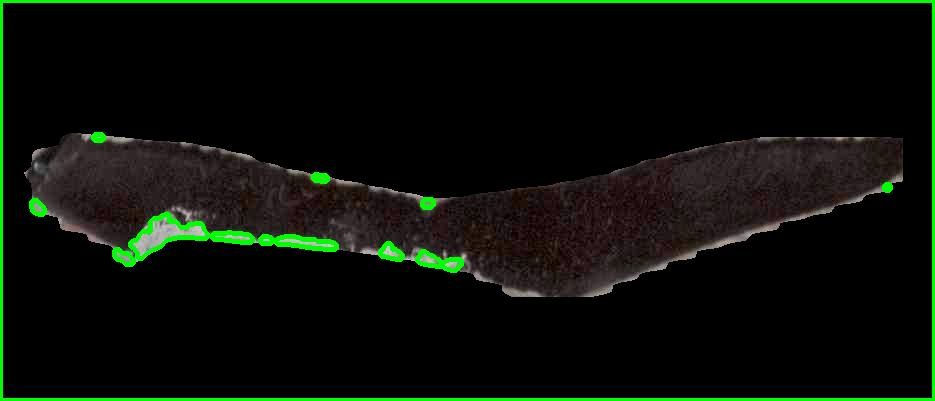
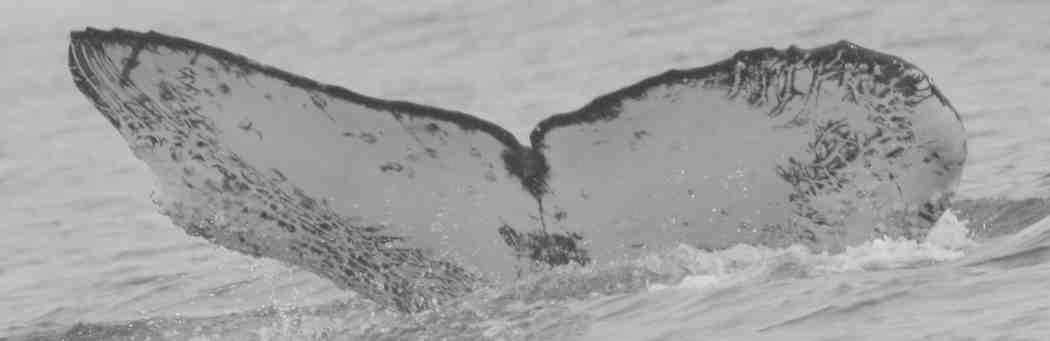
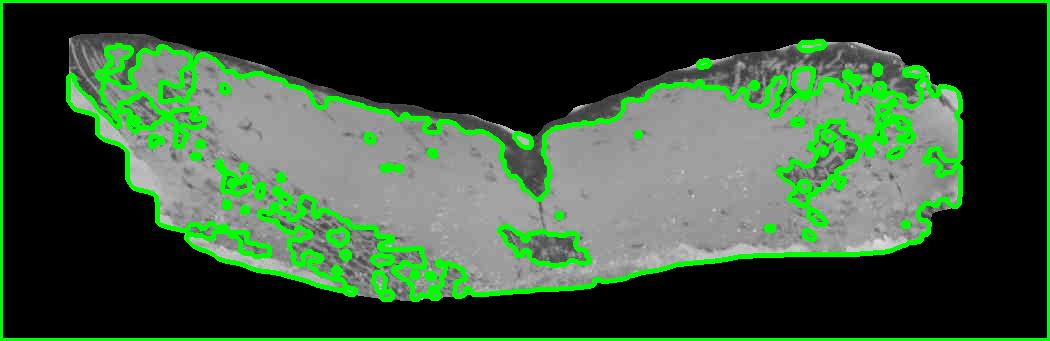
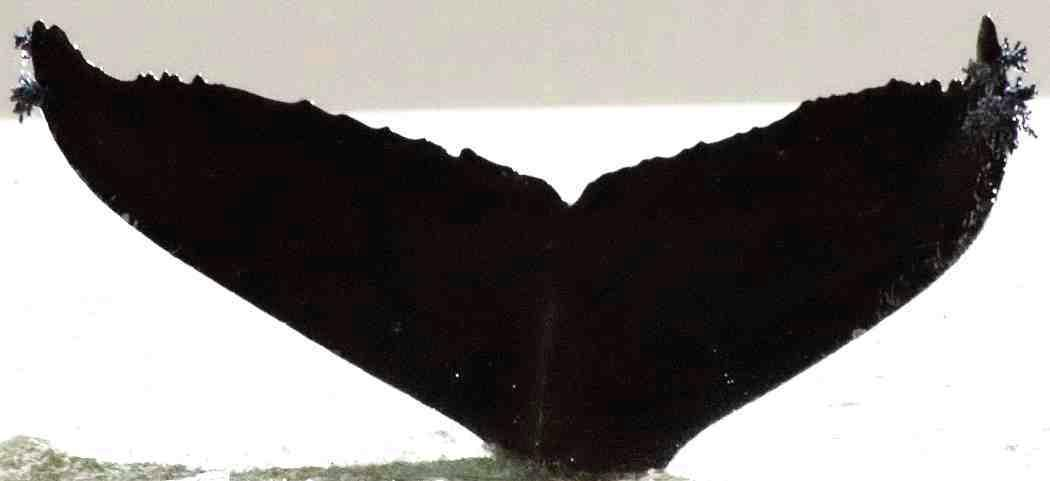
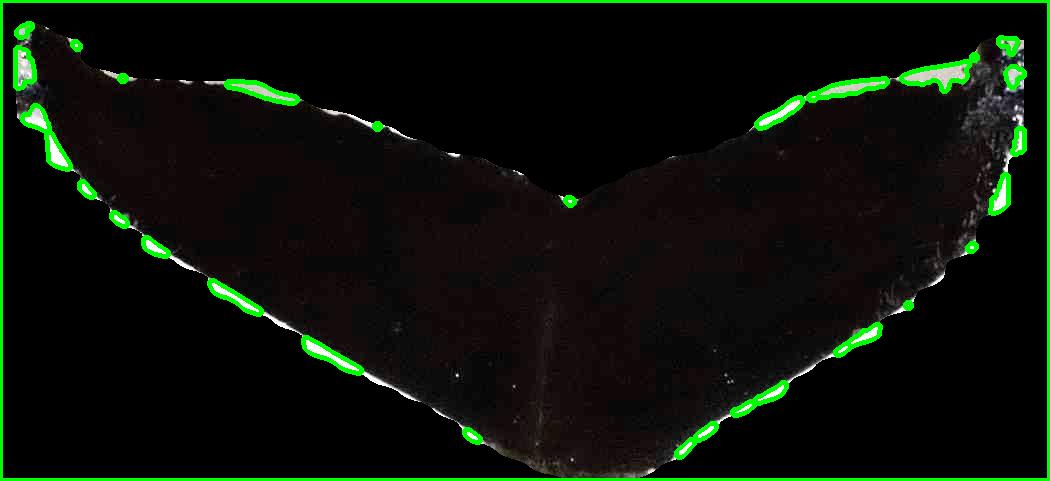
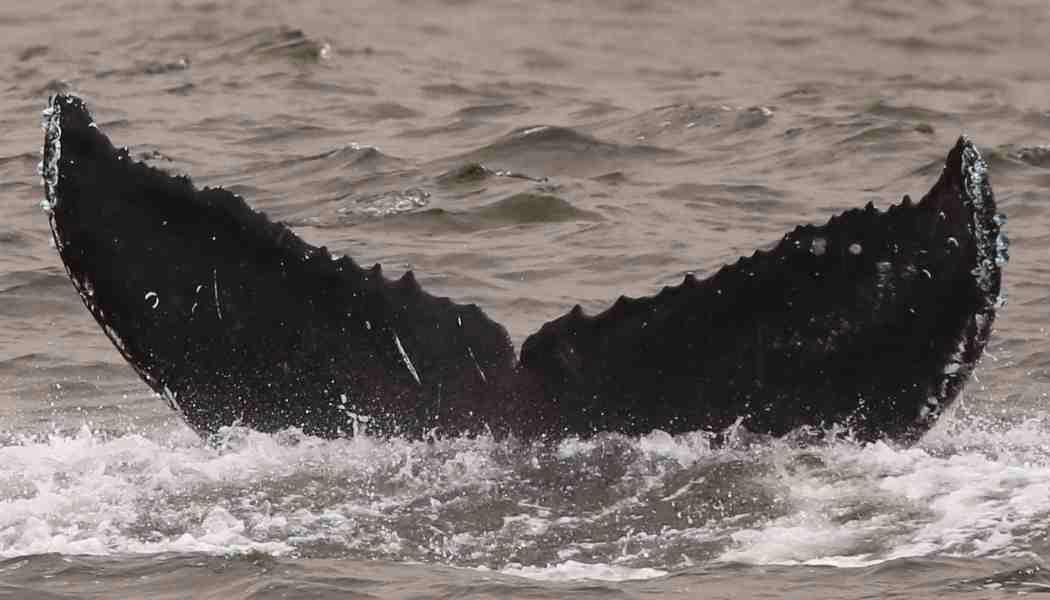
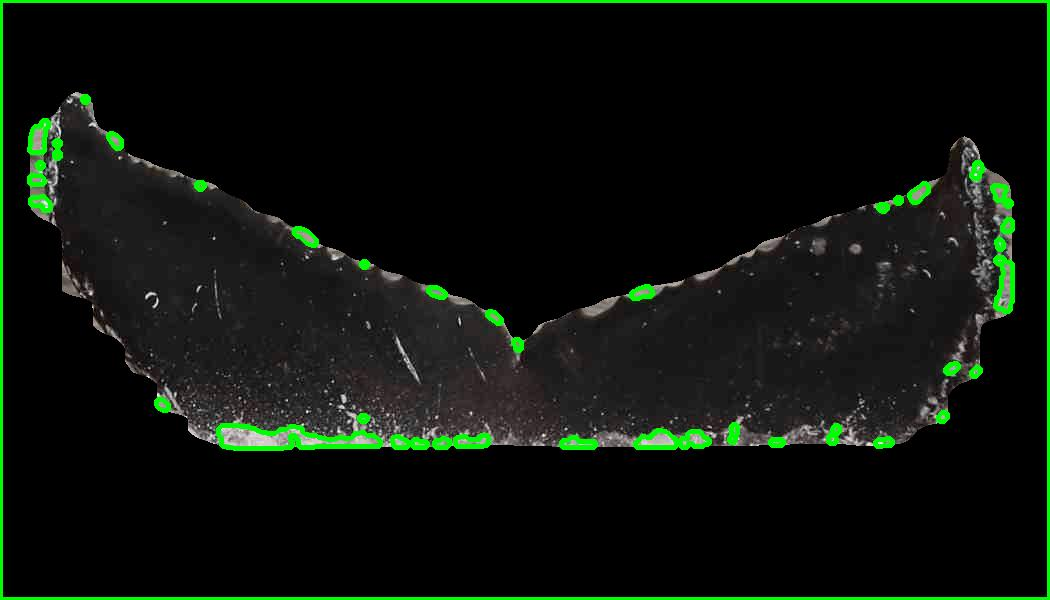
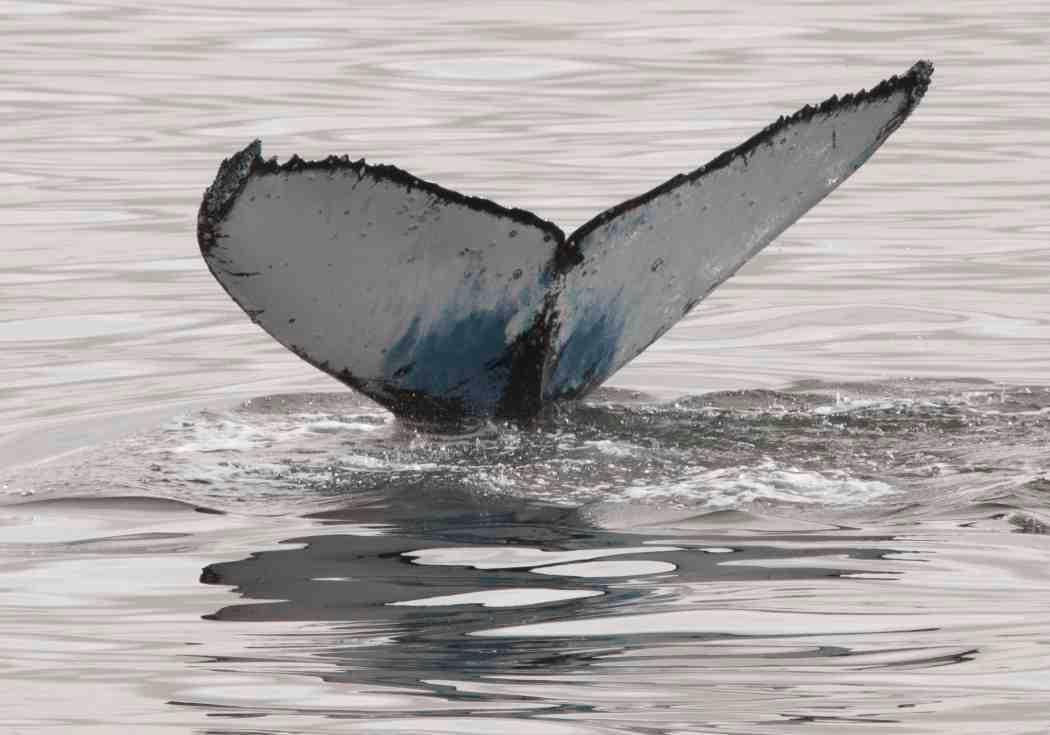
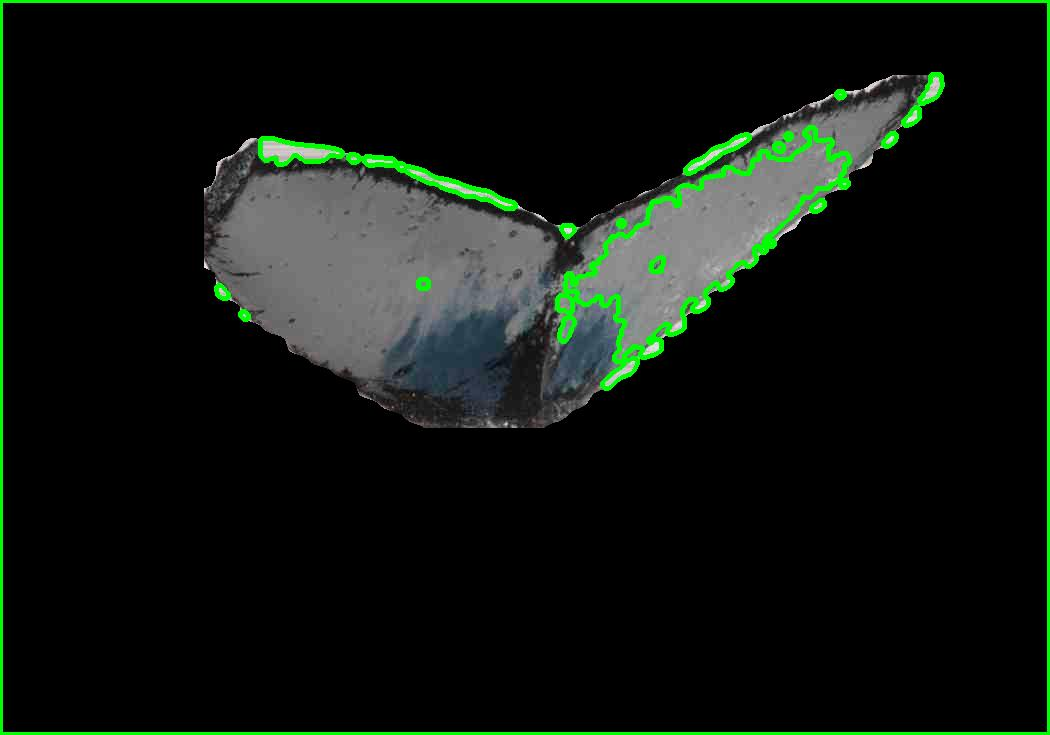
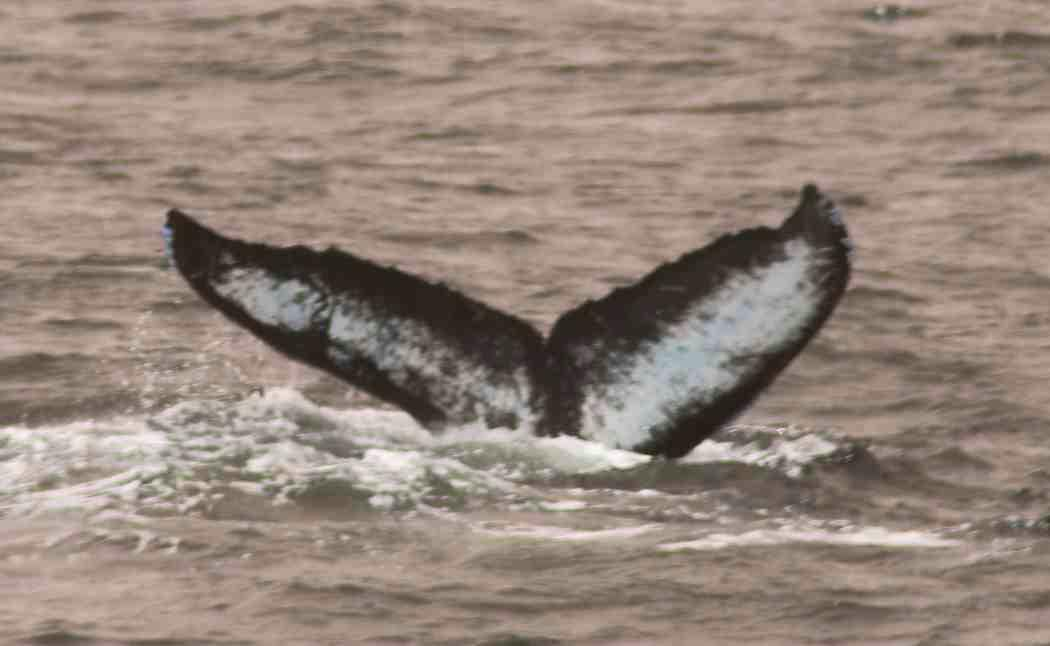
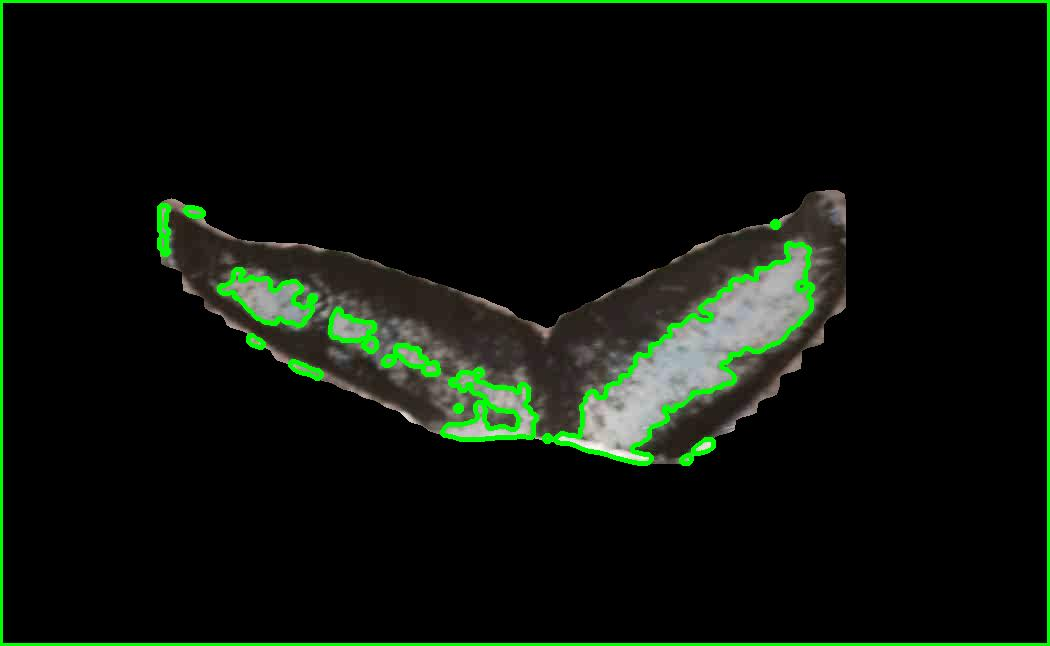
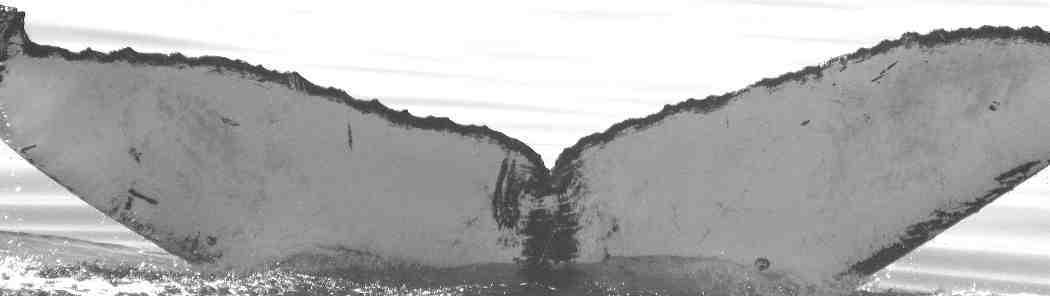
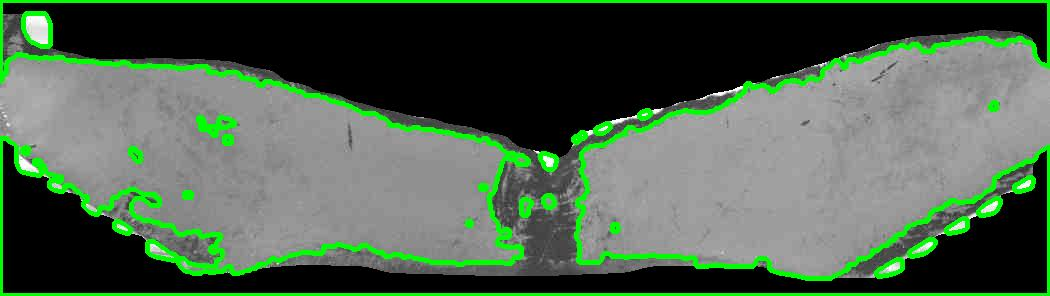
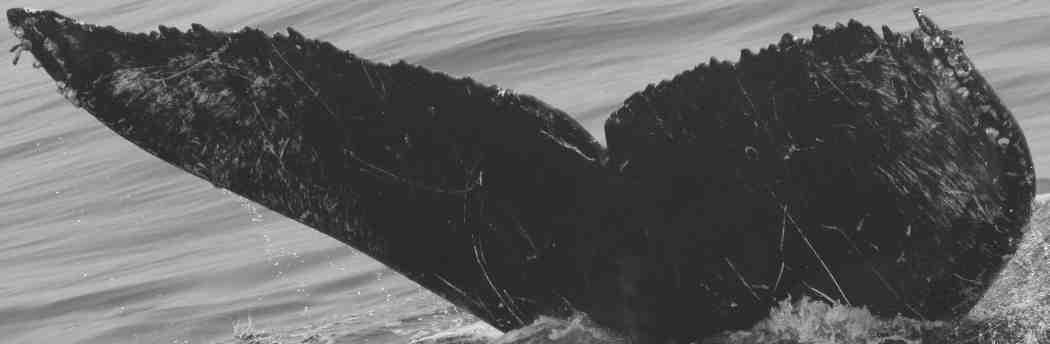
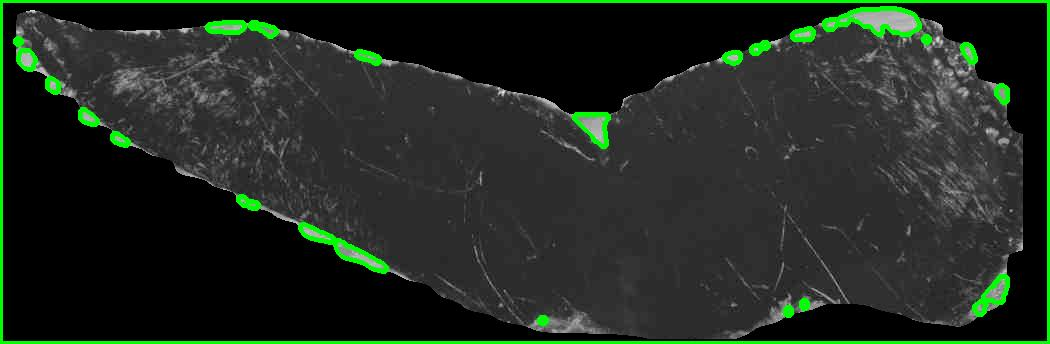

In [26]:
HTML(fpd[['files', 'fimg', 'fimge']].to_html(formatters={'fimg':image_formatter, 'fimge':image_formatter}, escape=False))

In [27]:
cv2.__version__

'3.4.1'

In [28]:
#sift = cv.SIFT()
sift = cv2.xfeatures2d.SIFT_create(300, contrastThreshold=0.1)
fpd['sifted']=fpd.bw.map(lambda bw: Image.fromarray(cv2.drawKeypoints(bw, sift.detect(bw, None), bw)))



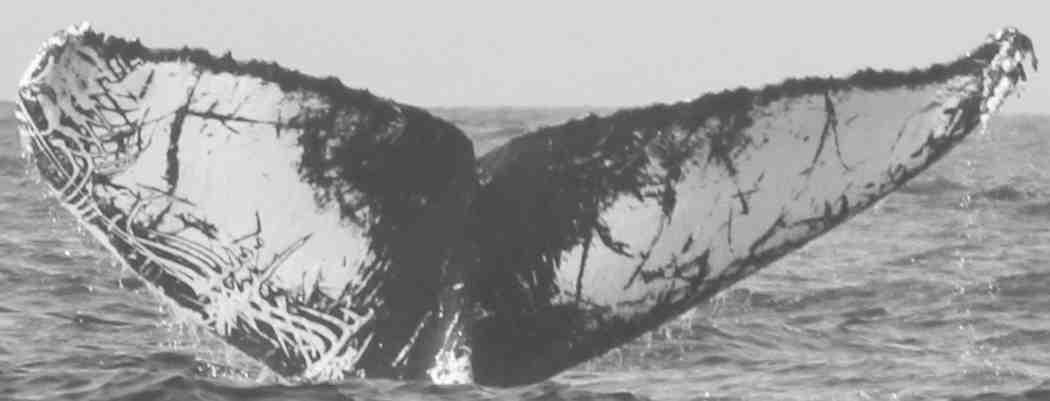
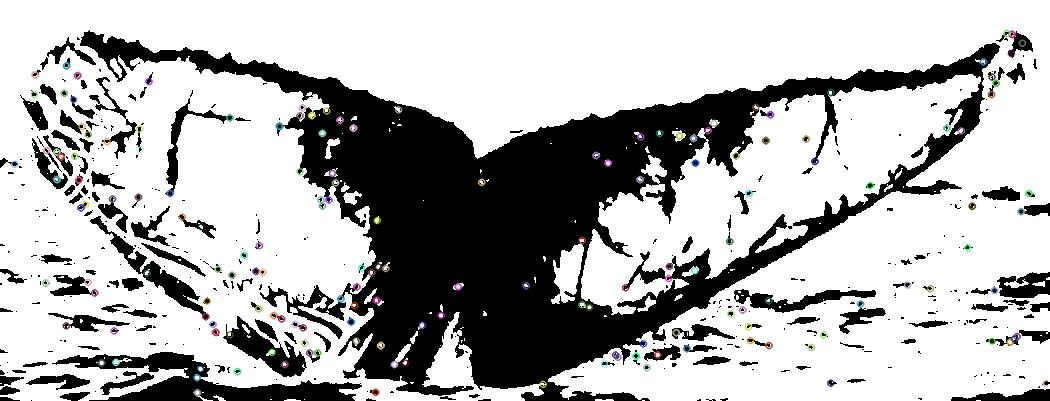
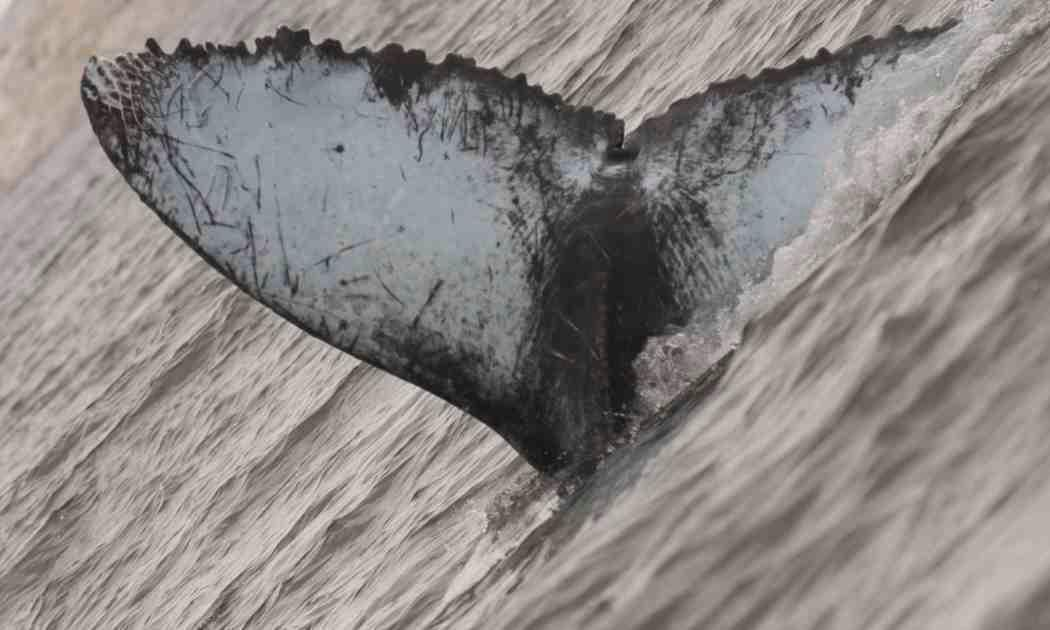
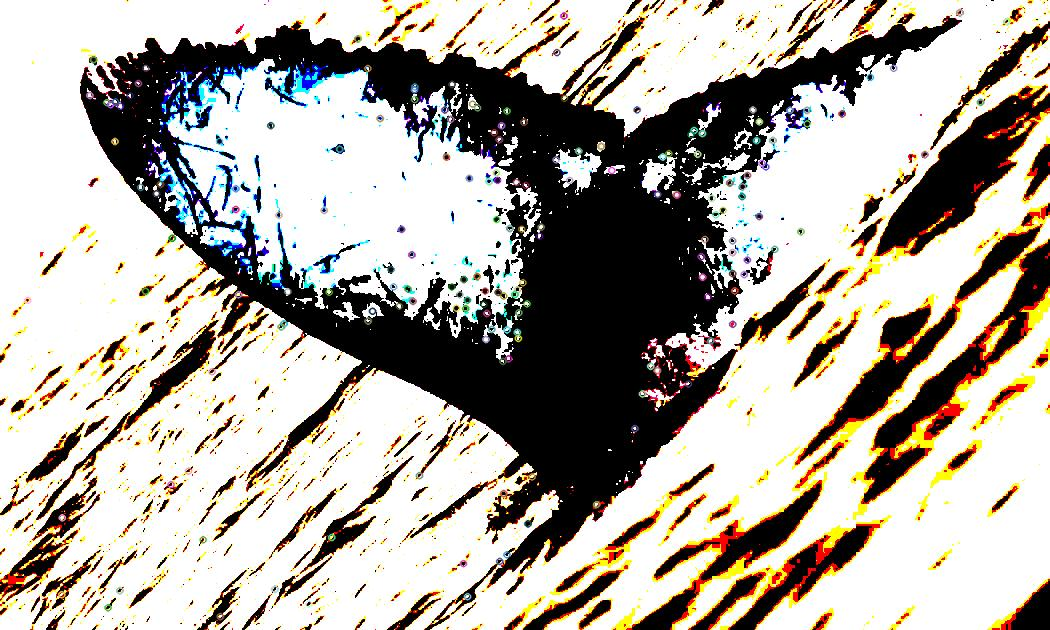
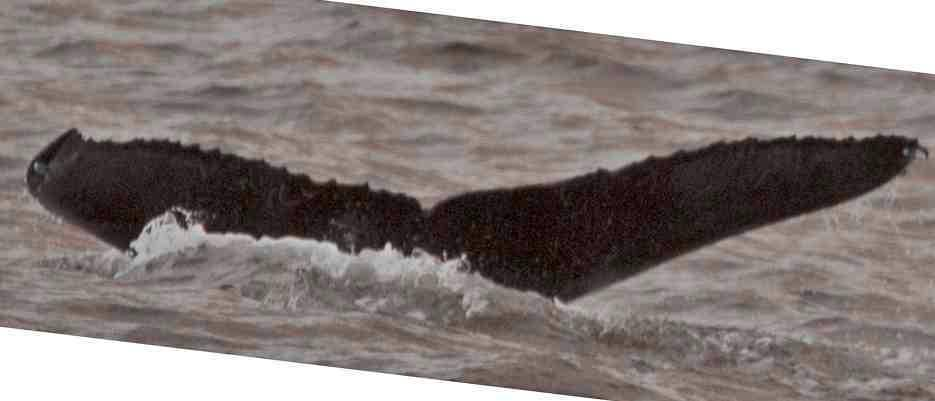
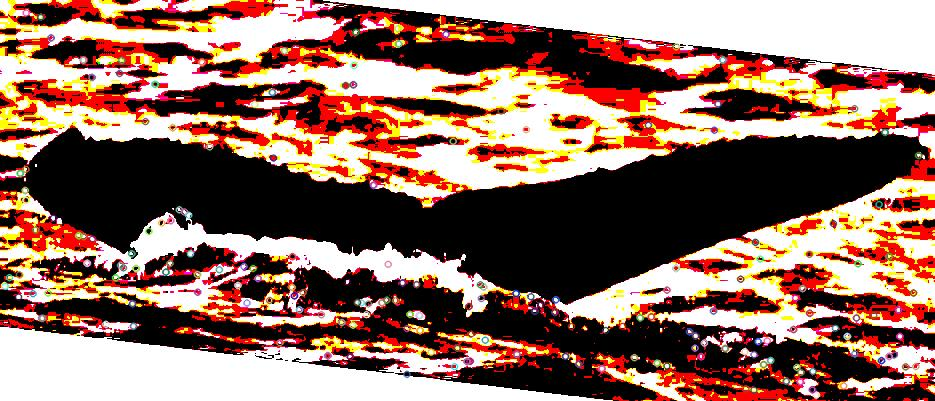
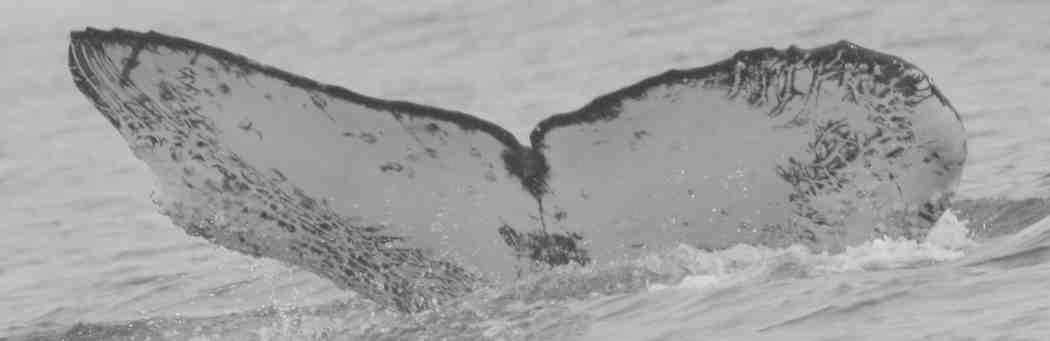
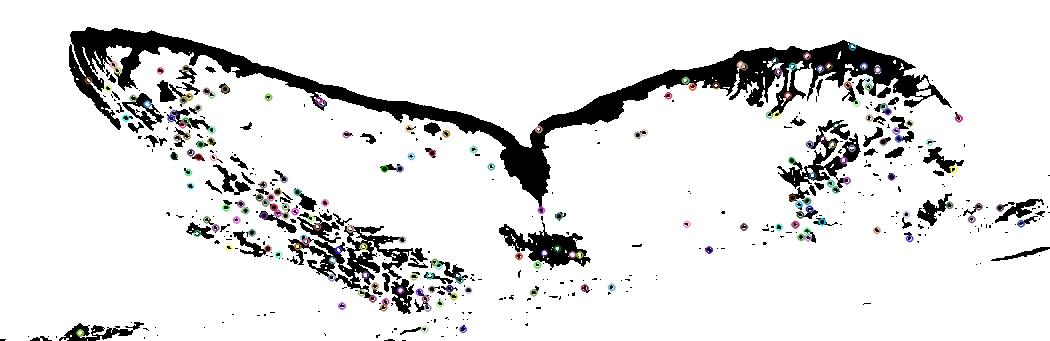
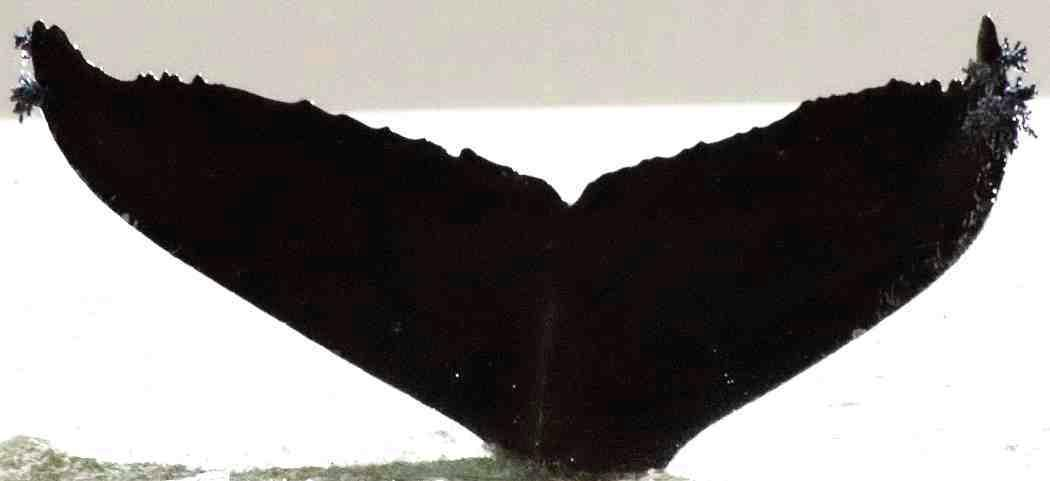
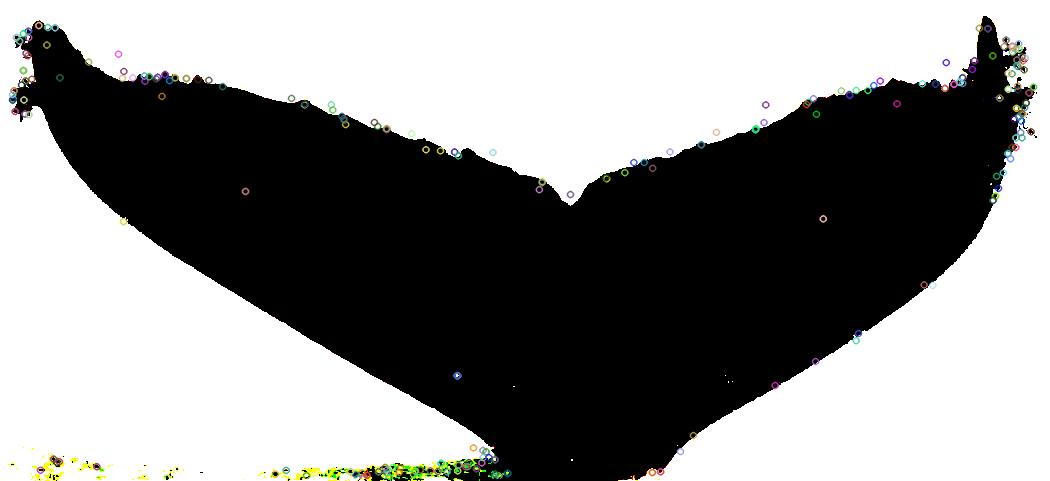
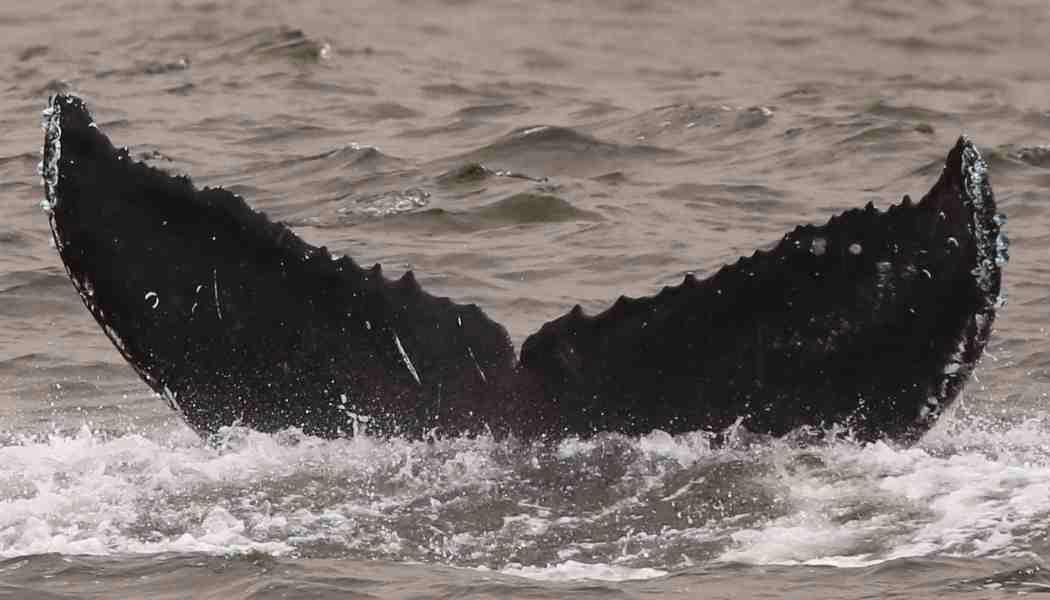
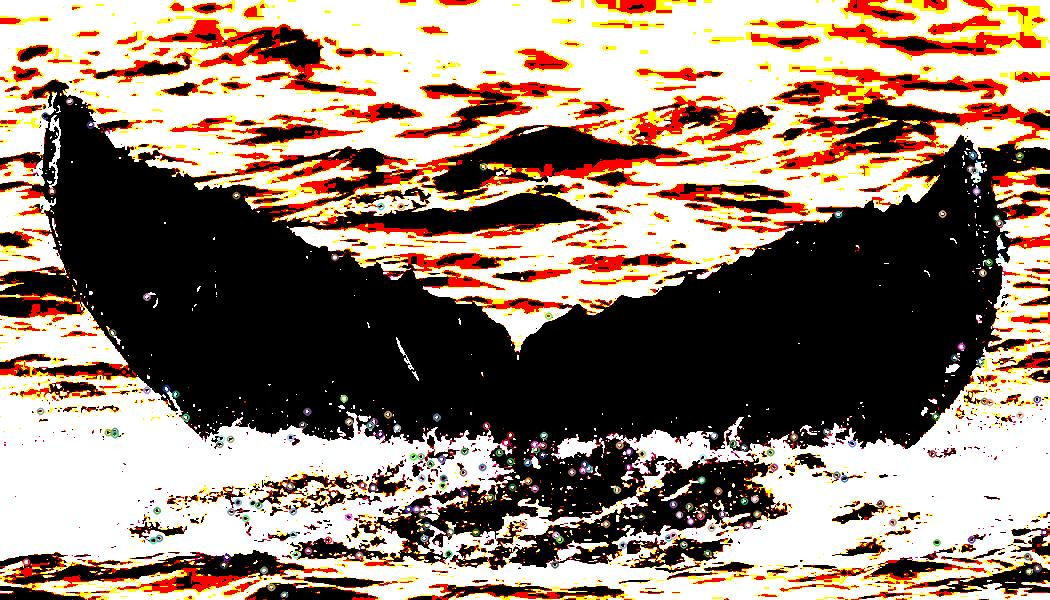
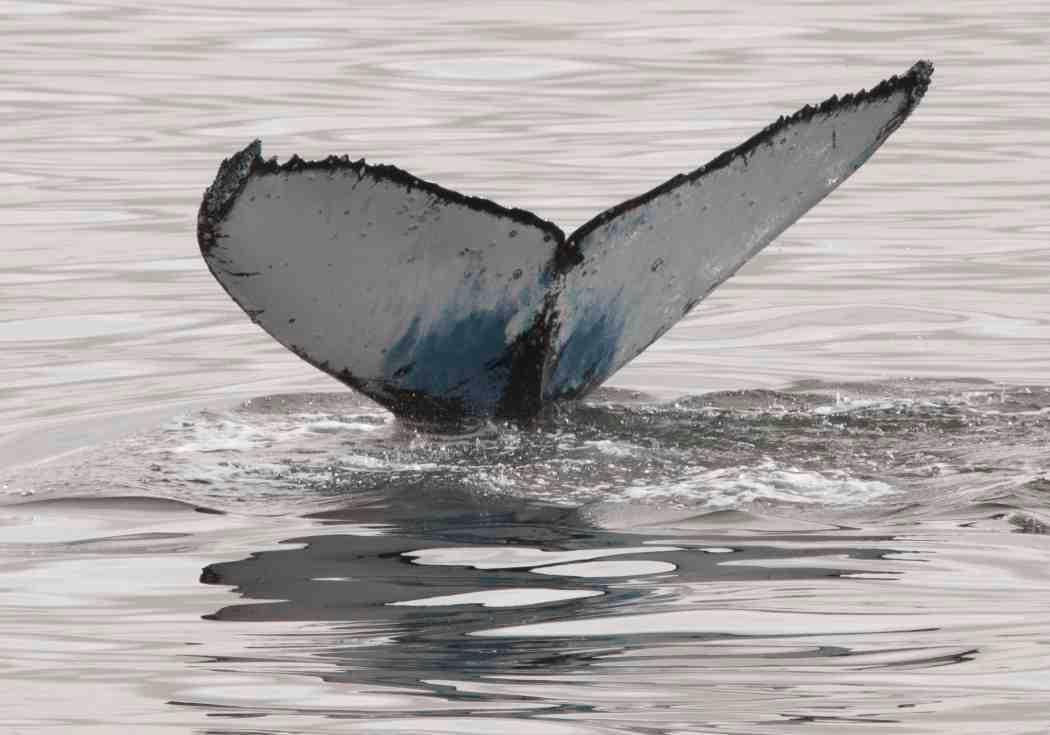
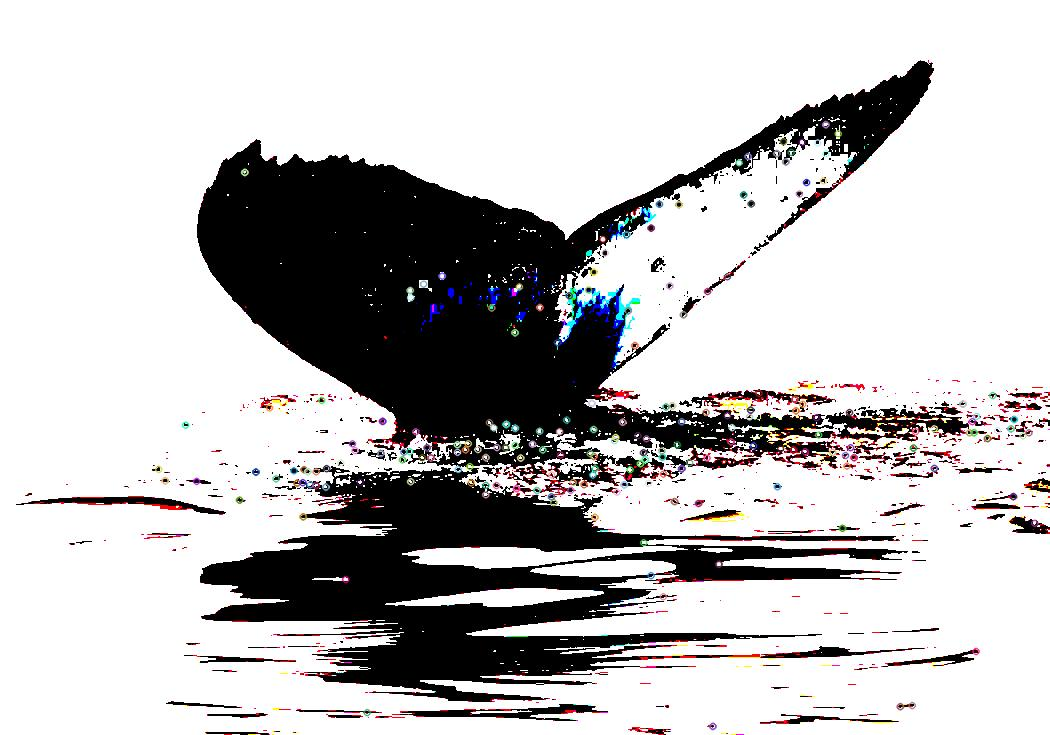
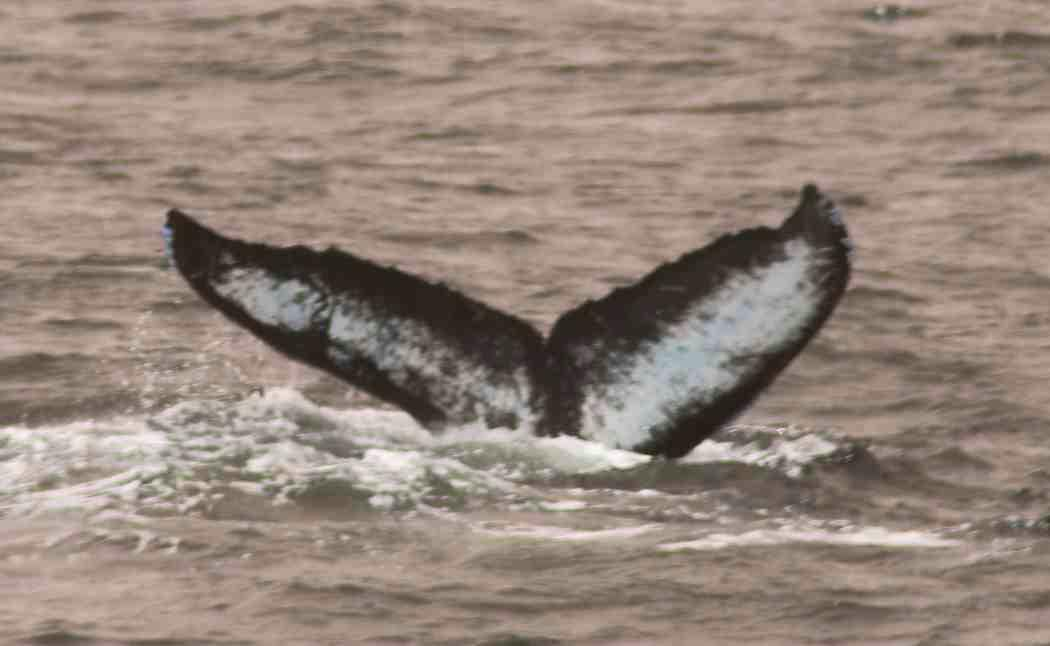
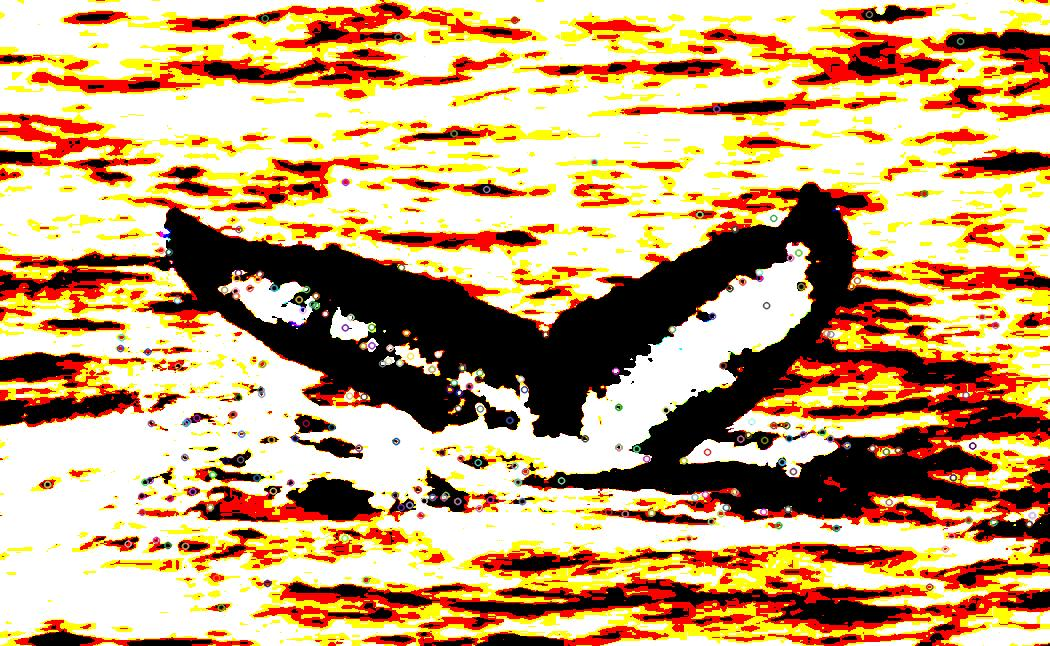
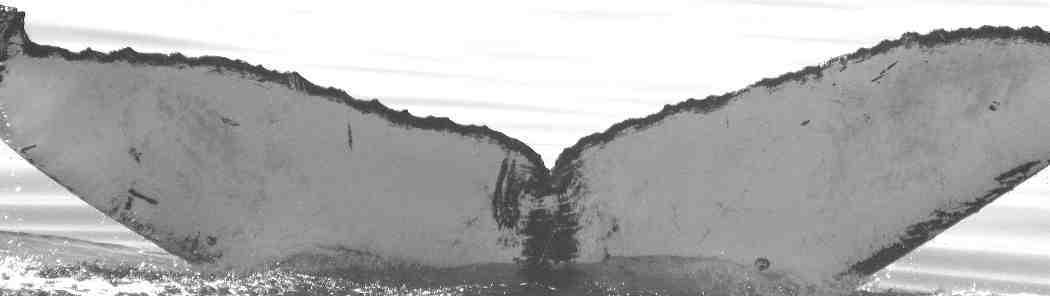
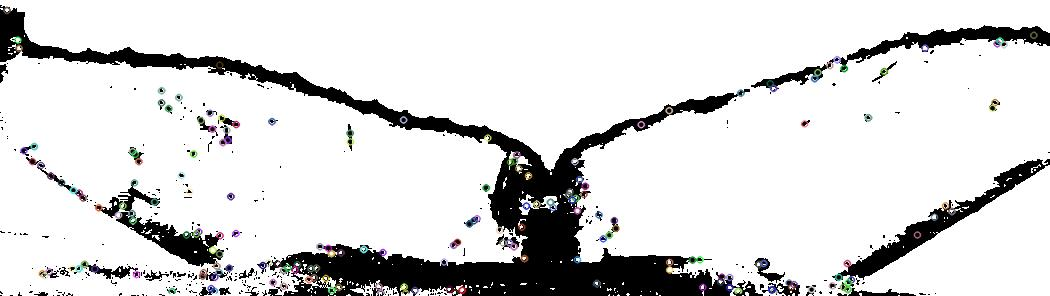
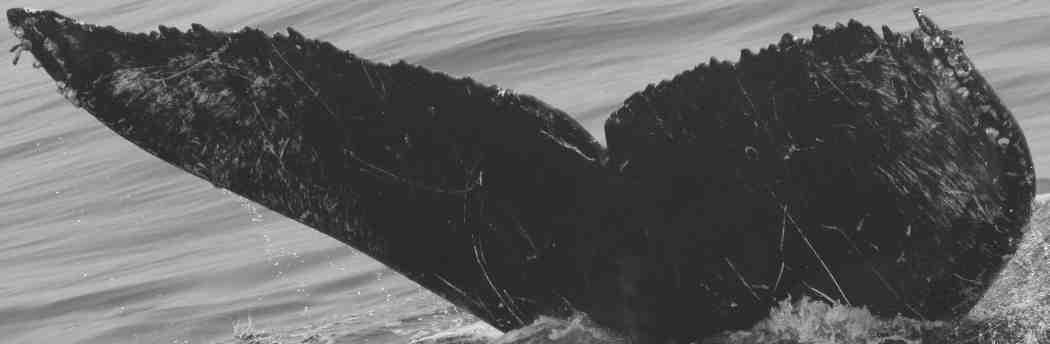
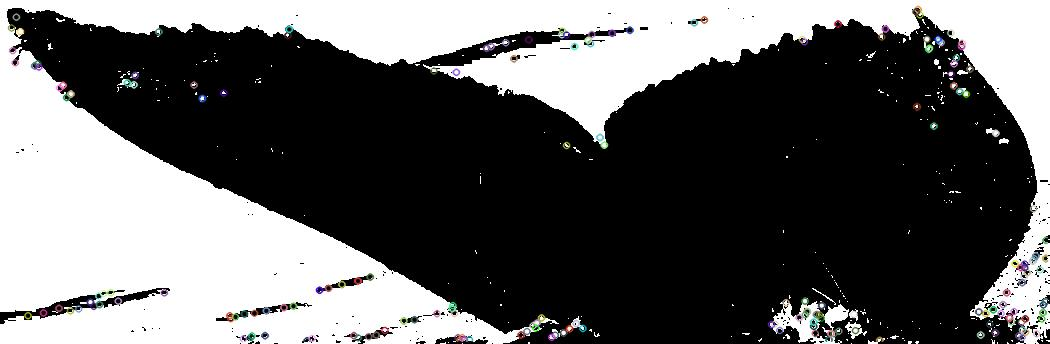

In [29]:
HTML(fpd[['files', 'fimg', 'sifted']].to_html(formatters={'sifted':image_formatter, 'fimg':image_formatter}, escape=False))

In [30]:
?cv2.xfeatures2d.SIFT_create()


In [31]:
img=Image.open('/home/ilya/ai/kaggle/whales/input/train/8baaa687.jpg')
print(img.size)

(1050, 700)


In [32]:
#import cv2.cv as cv
#from cv2 import cv

im=cv2.imread('/home/ilya/ai/kaggle/whales/input/train/8baaa687.jpg', cv2.IMREAD_COLOR)
print(im.shape)

(700, 1050, 3)


In [33]:
# Laplace on a gray scale picture
gray=cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
print(gray.shape)

(700, 1050)


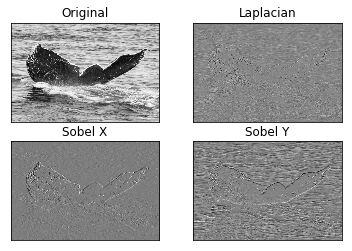

In [34]:
img=cv2.GaussianBlur(gray,(3,3),0)

laplacian = cv2.Laplacian(img,cv2.CV_64F)
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)  # x
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)  # y

plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.show()

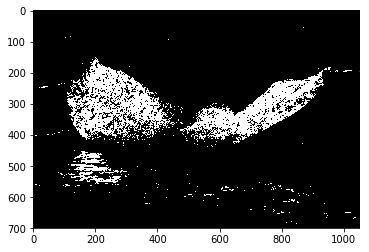

In [35]:

aperture=3

ret, thresholded = cv2.threshold(im, 50, 255, cv2.THRESH_BINARY_INV)
plt.imshow(thresholded)

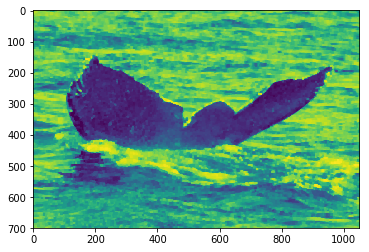

In [36]:

element = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
#cv.CreateStructuringElementEx(5*2+1, 5*2+1, 5, 5, cv.CV_SHAPE_RECT)

morphed = cv2.morphologyEx(gray, cv2.MORPH_OPEN, element) #Open and close to make appear contours
morphed = cv2.morphologyEx(morphed, cv2.MORPH_CLOSE, element)
plt.imshow(morphed)

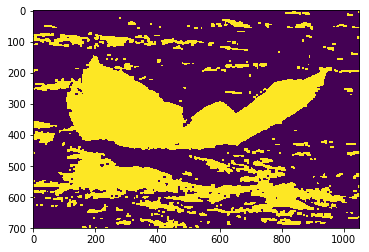

In [37]:
ret, thresholded = cv2.threshold(morphed, 128, 255, cv2.THRESH_BINARY_INV)
plt.imshow(thresholded)

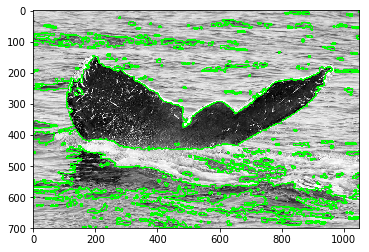

In [38]:
im2, contours, hierarchy = cv2.findContours(thresholded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
imgcopy=np.copy(im)
cv2.drawContours(imgcopy, contours, -1, (0,255,0), 3)
imgcopy.shape
plt.imshow(imgcopy)

In [40]:
import PIL
from PIL import ImageDraw, Image

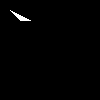

In [41]:
mask = PIL.Image.new('1', (100, 100))
draw = ImageDraw.Draw(mask)
draw.polygon([(10,10),(20,20),(30,20)], fill='white')
mask

In [42]:
d1={'a':1,
   'b':2}
d2={'c':3, 'd':5}

dict(list(d1.items())+list(d2.items()))

{'a': 1, 'b': 2, 'c': 3, 'd': 5}

<h1>Whale wrangling<h1>
Let's do some actual whale data wrangling now

In [43]:
train = pd.read_csv('../input/train.csv')

In [44]:
train[train['Id']=='w_1287fbc']

Image         Id
1     000466c4.jpg  w_1287fbc
253   0603a403.jpg  w_1287fbc
775   13503533.jpg  w_1287fbc
1197  1f2913e3.jpg  w_1287fbc
1670  2c3b34a3.jpg  w_1287fbc
1673  2c4813a1.jpg  w_1287fbc
2340  3cdd7fa7.jpg  w_1287fbc
2478  40abf606.jpg  w_1287fbc
2622  445c2164.jpg  w_1287fbc
2687  4604b292.jpg  w_1287fbc
3130  514cf008.jpg  w_1287fbc
4175  6d82e3d0.jpg  w_1287fbc
4283  7060ba65.jpg  w_1287fbc
4355  71a4fc90.jpg  w_1287fbc
4441  738fb42a.jpg  w_1287fbc
5039  8305abbf.jpg  w_1287fbc
5196  871d522d.jpg  w_1287fbc
5206  87649728.jpg  w_1287fbc
5519  8f1fb719.jpg  w_1287fbc
5520  8f2b69b8.jpg  w_1287fbc
5591  91052943.jpg  w_1287fbc
5624  91b704dc.jpg  w_1287fbc
5861  97f7fb07.jpg  w_1287fbc
6463  a7d28984.jpg  w_1287fbc
6764  af823c5a.jpg  w_1287fbc
7004  b5f01672.jpg  w_1287fbc
7670  c72123ef.jpg  w_1287fbc
7951  ce6abadc.jpg  w_1287fbc
8027  d02b1784.jpg  w_1287fbc
8031  d040e670.jpg  w_1287fbc
8424  db147df2.jpg  w_1287fbc
8674  e19655a4.jpg  w_1287fbc
9087  ed284e79.jpg  w_1287fbc
9446  f5ac7c84.jpg  w_1287fbc

In [45]:
td = pd.DataFrame(train[train['Id']=='w_1287fbc'])
td['file']=train.Image.map(lambda f: '/home/ilya/ai/kaggle/whales/input/train/'+f)


In [46]:
td['fimgs']=td.file.map(lambda file: process_image(file))

In [49]:
td['fimg']=td.fimgs.map(lambda imgs: imgs[0])
td['fimgm']=td.fimgs.map(lambda imgs: imgs[1])
td['fimge']=td.fimgs.map(lambda imgs: imgs[2])

td['bw']=td.fimg.map(lambda img: cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)[1])

sift = cv2.xfeatures2d.SIFT_create(300, contrastThreshold=0.01)
td['sifted']=td.fimgm.map(lambda img: Image.fromarray(cv2.drawKeypoints(img, sift.detect(img, None), img)))



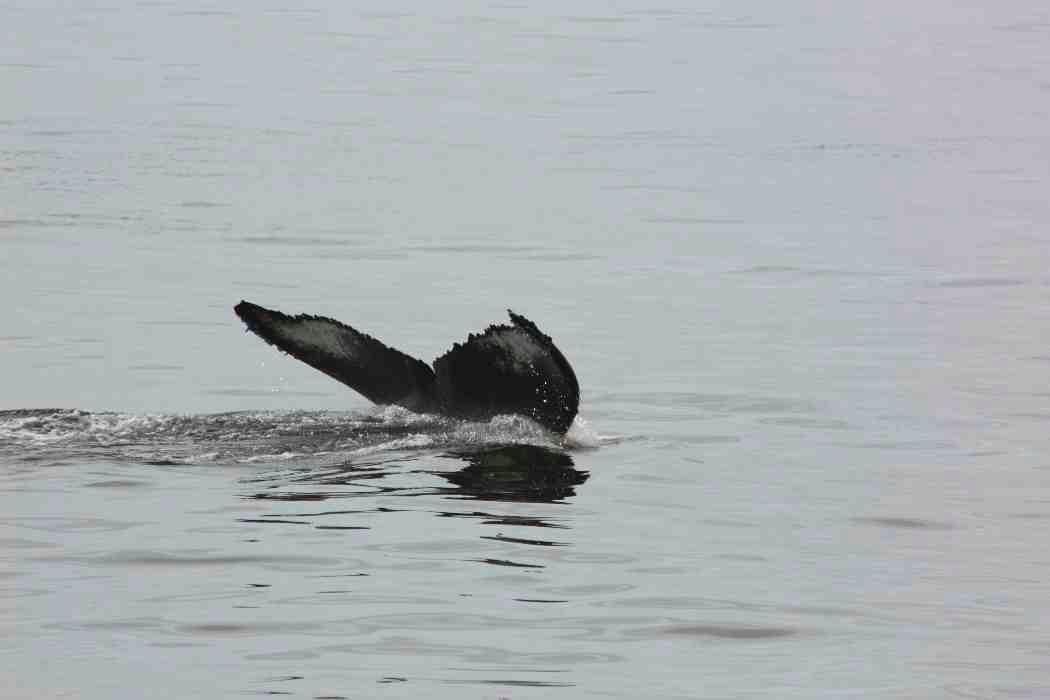
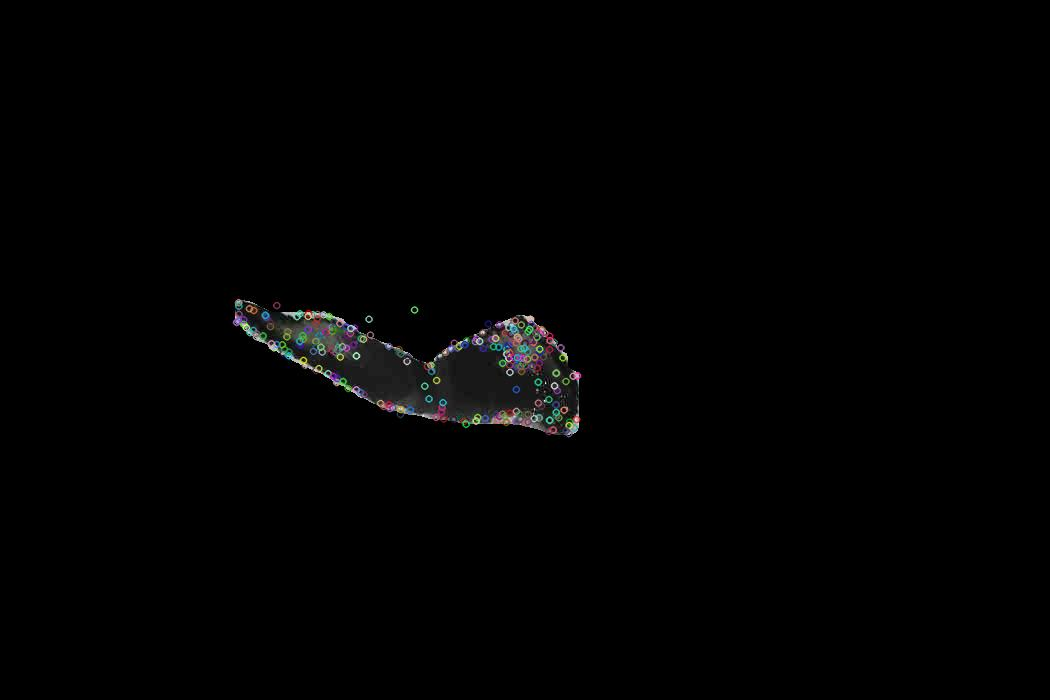
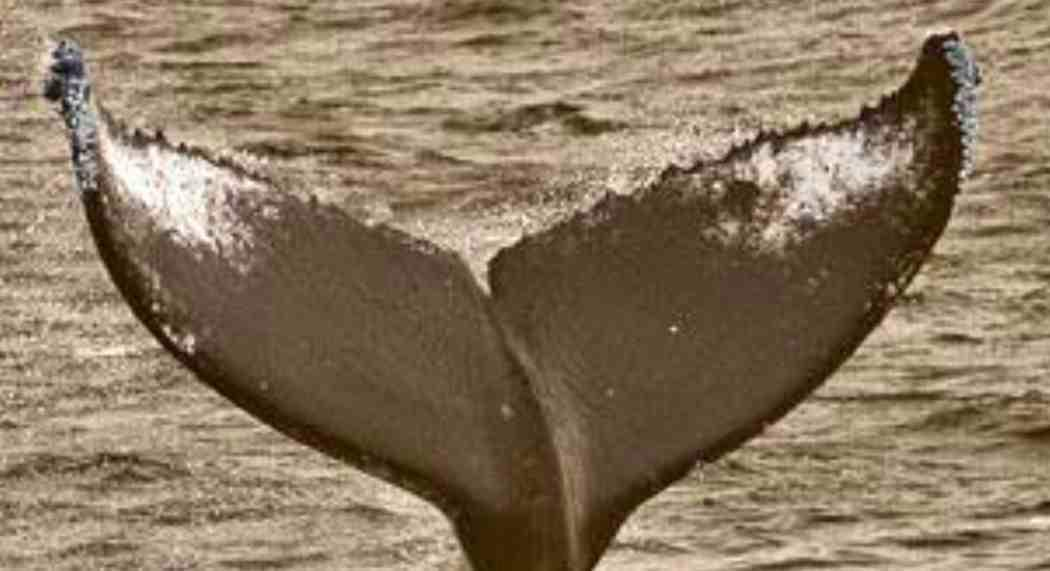
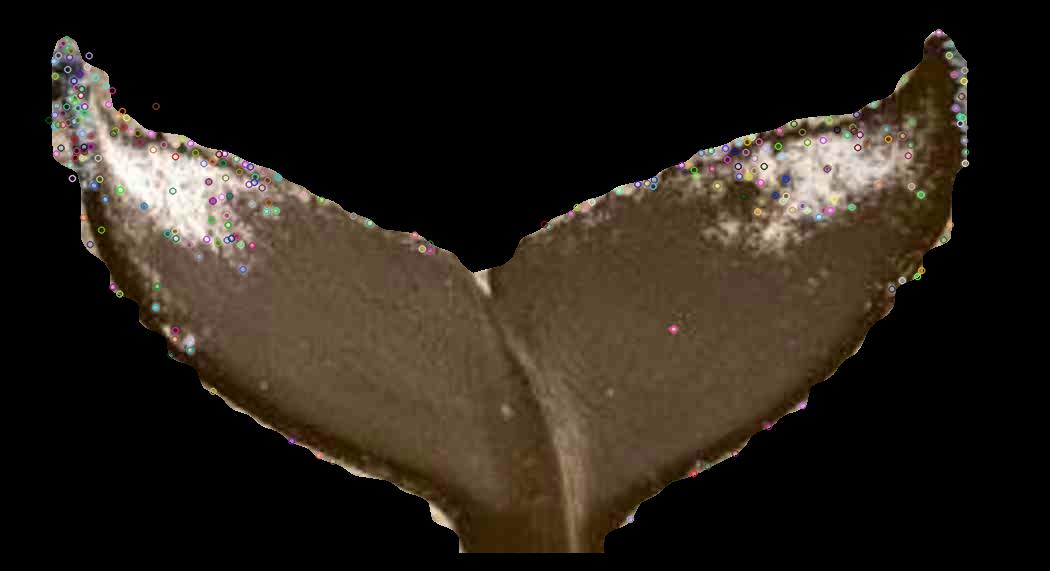
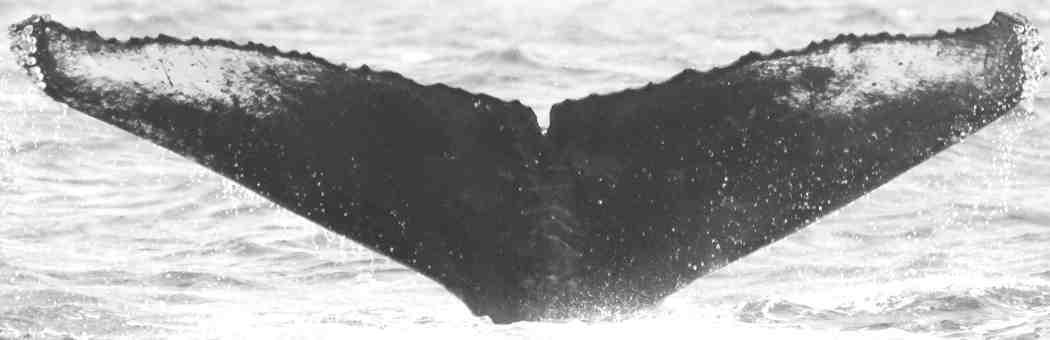
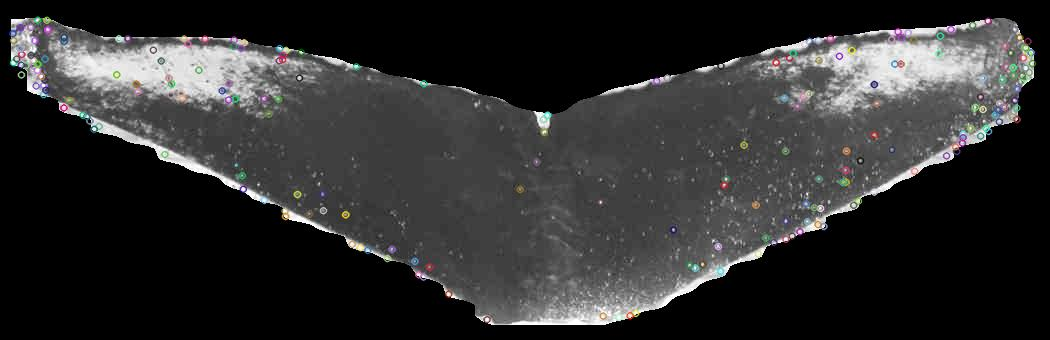
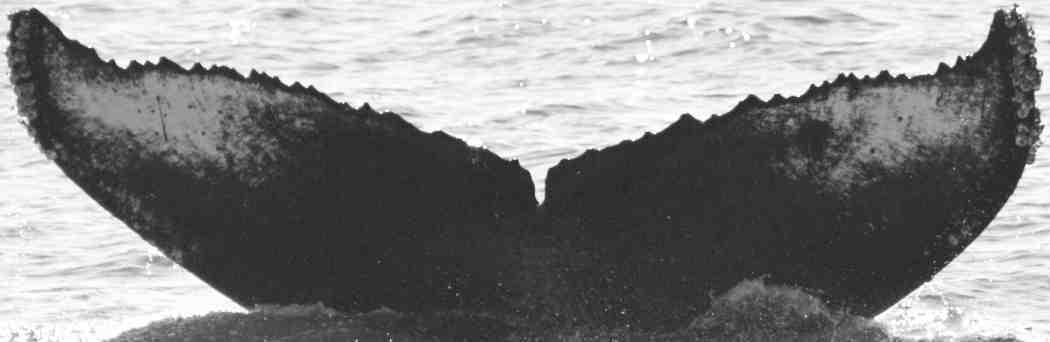
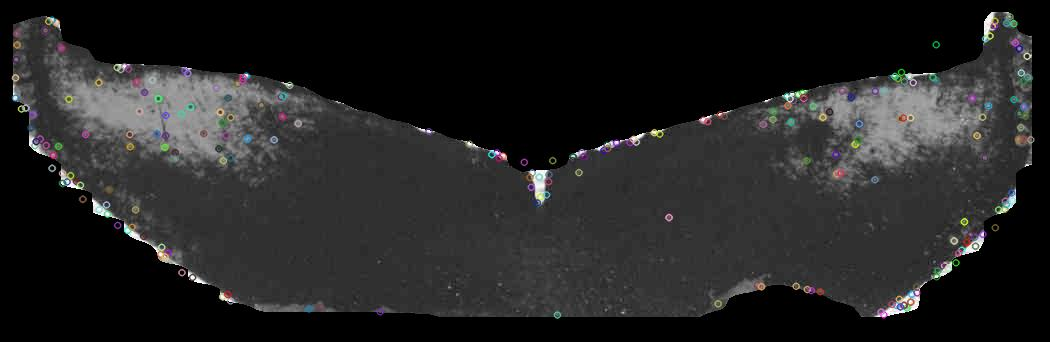
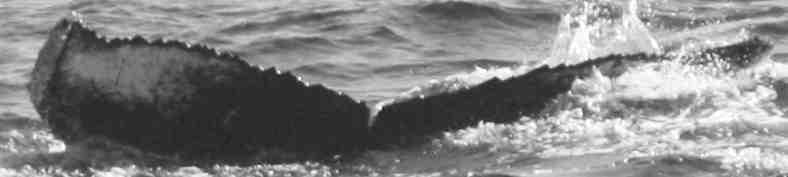
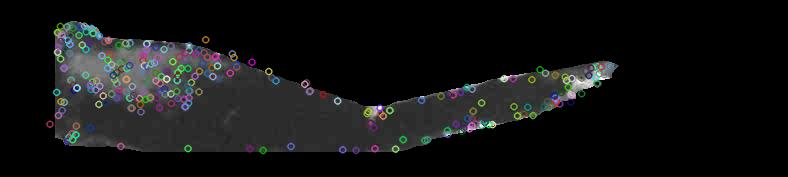
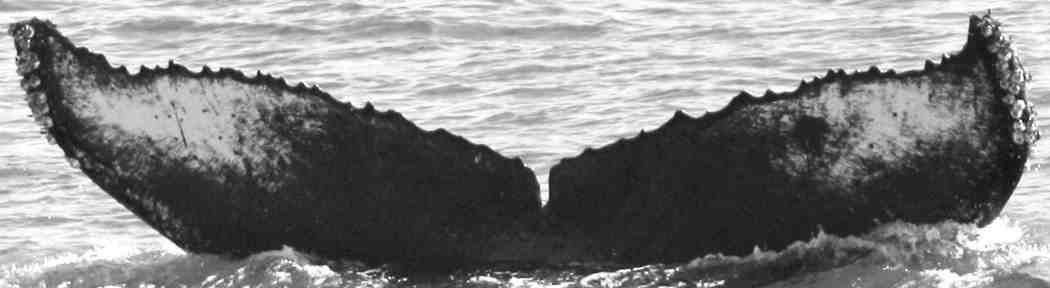
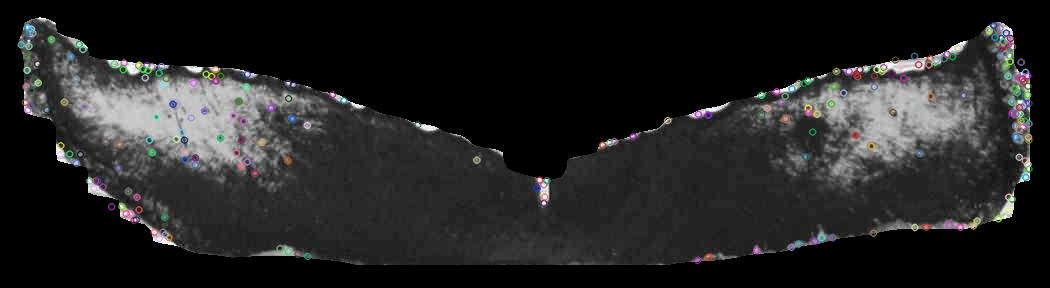
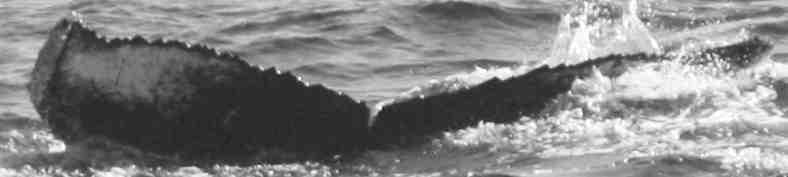
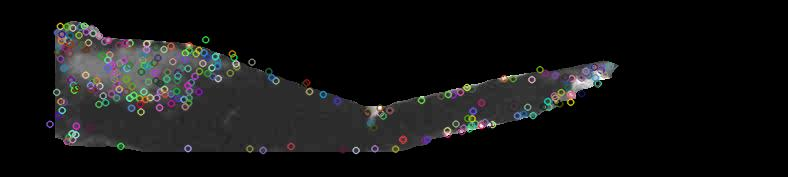
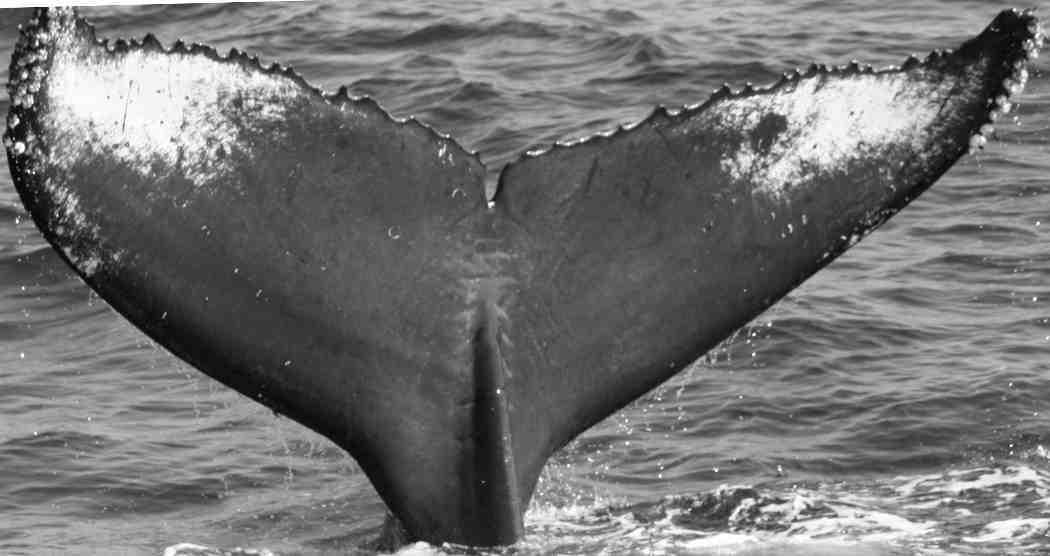
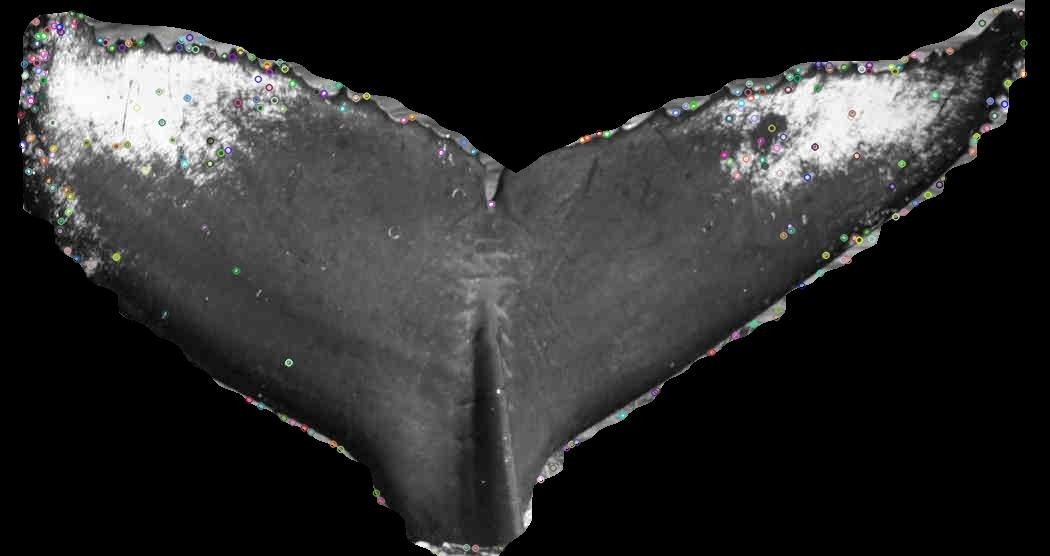
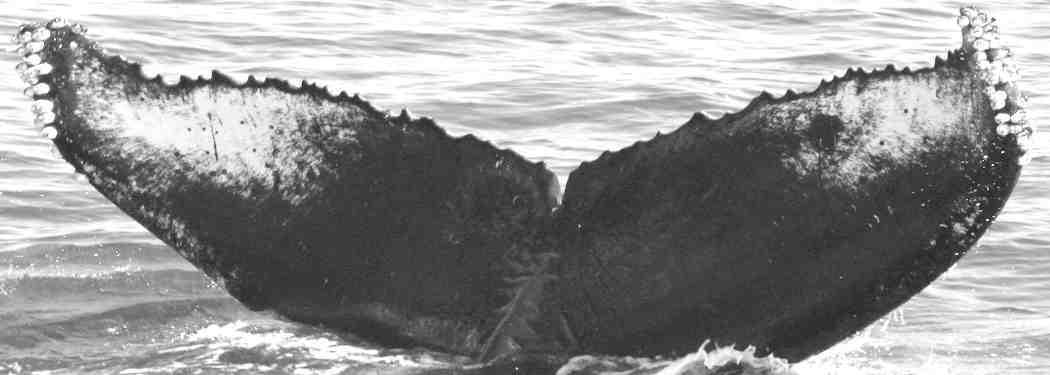
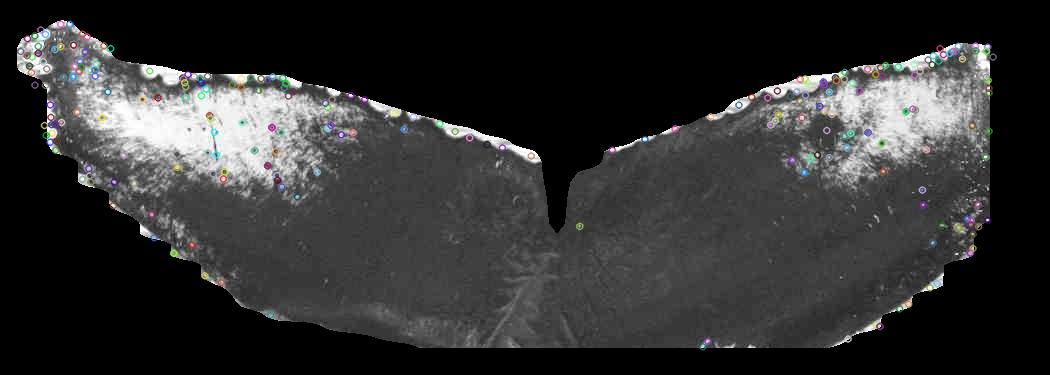
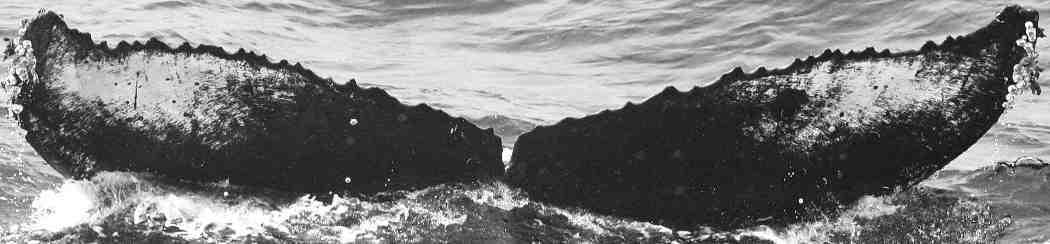
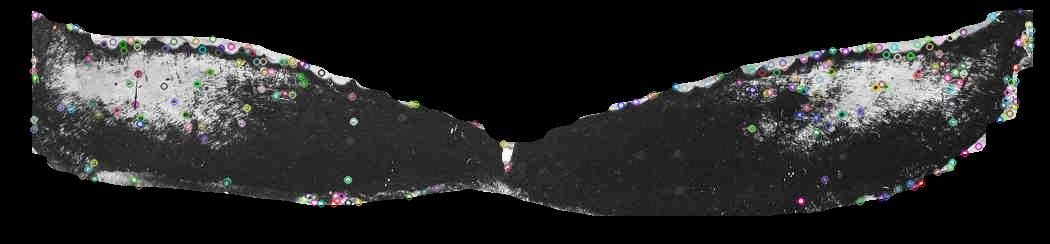
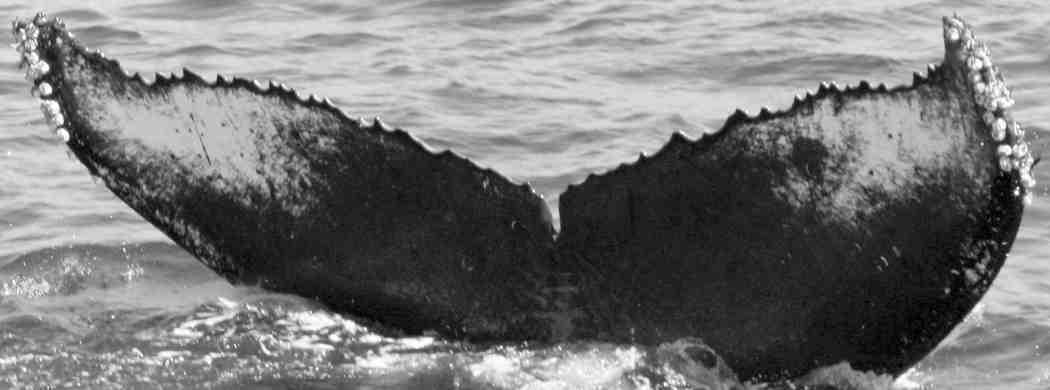
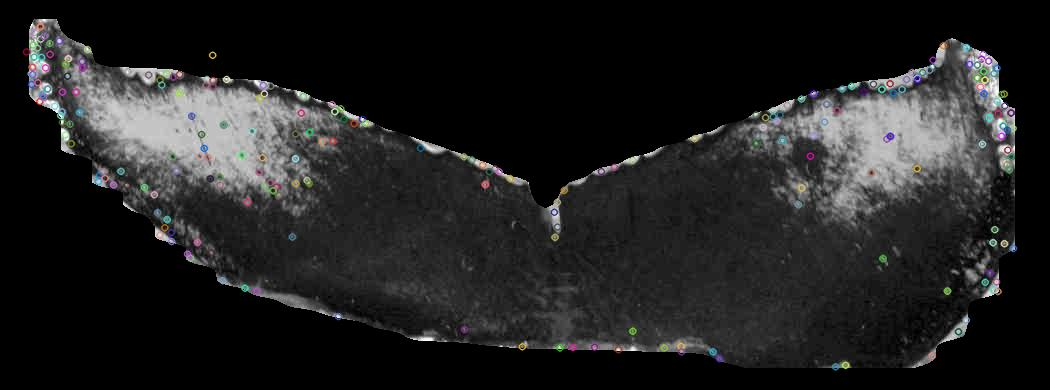
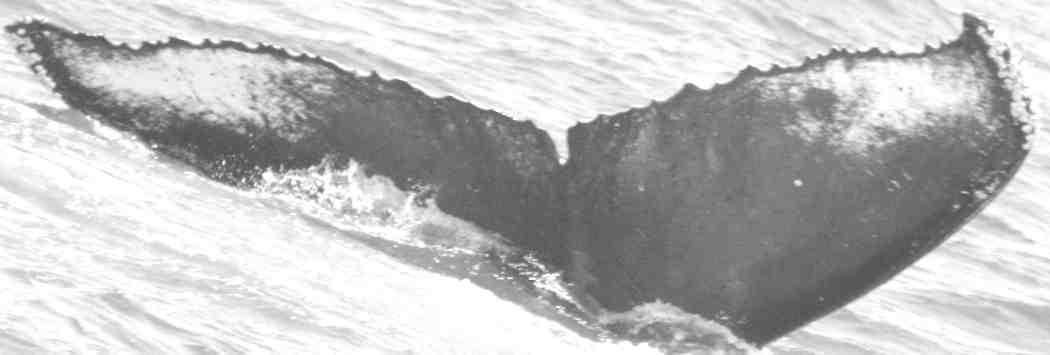
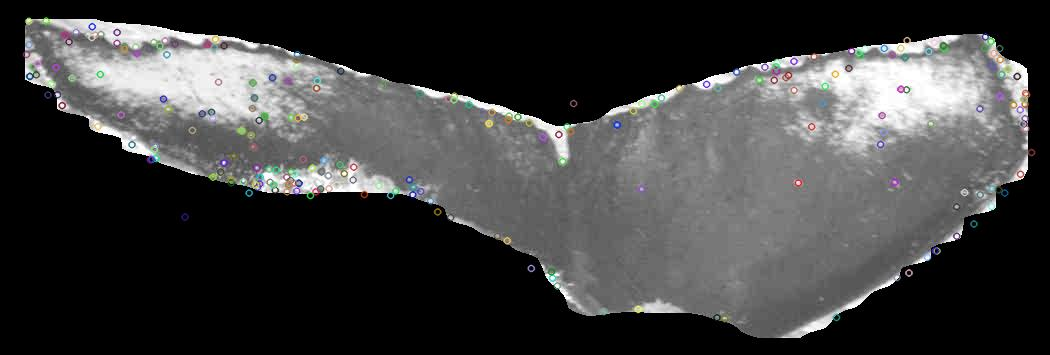
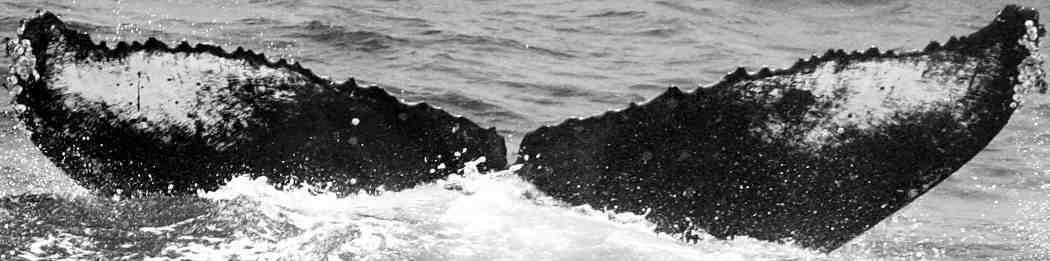
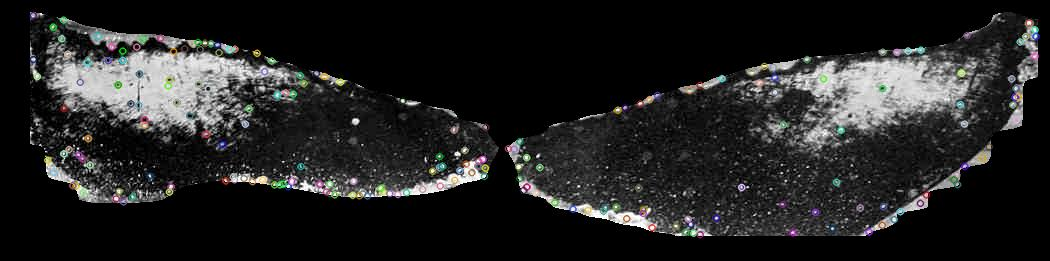
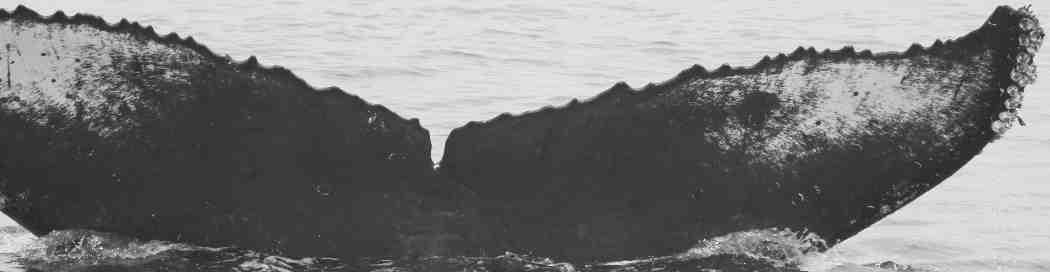
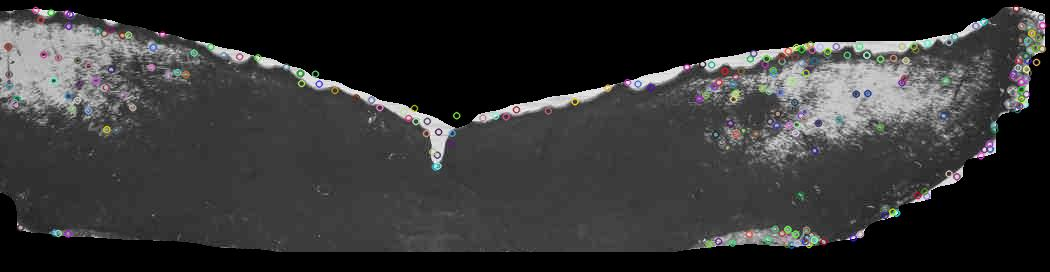
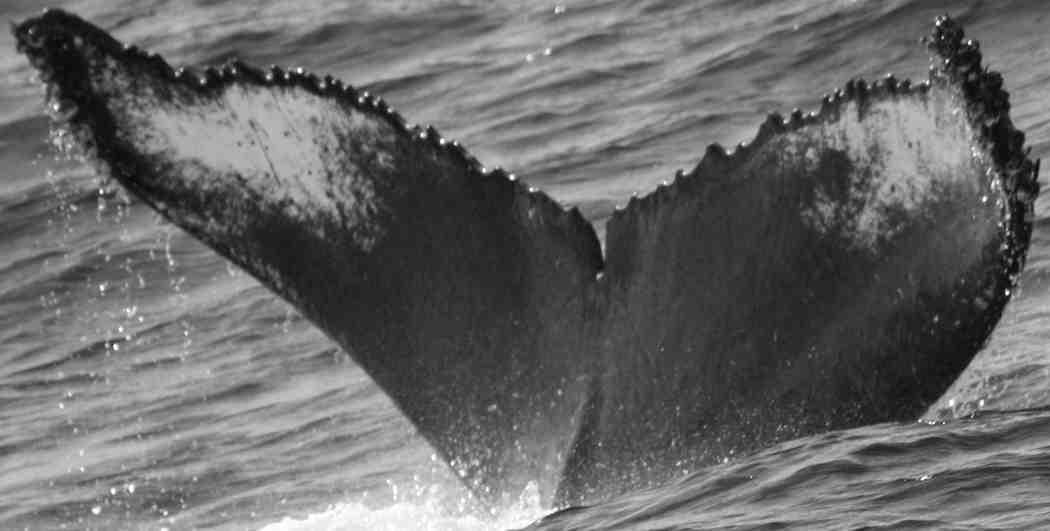
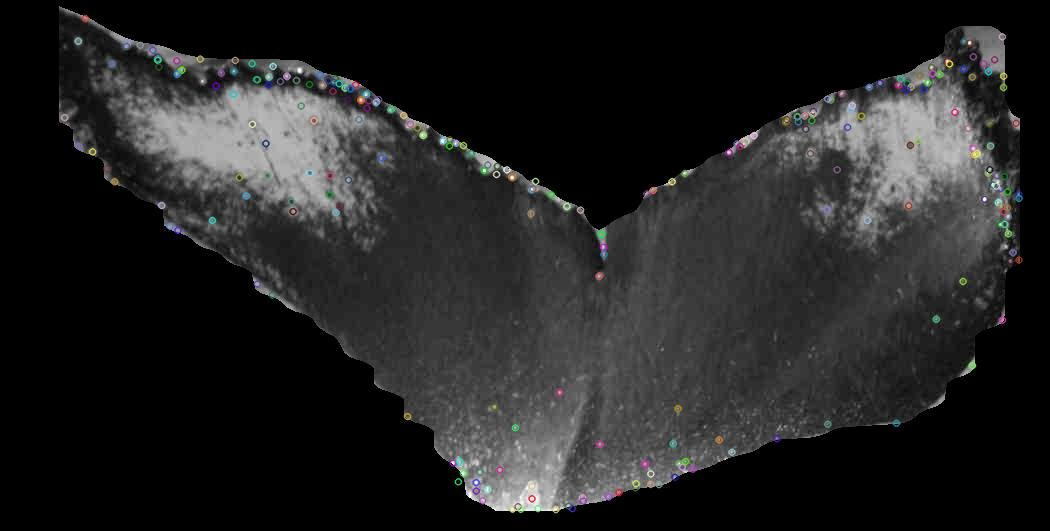
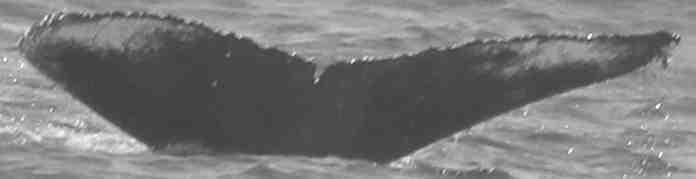
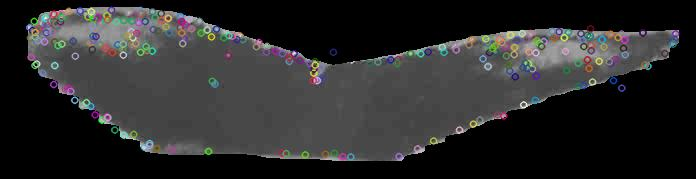
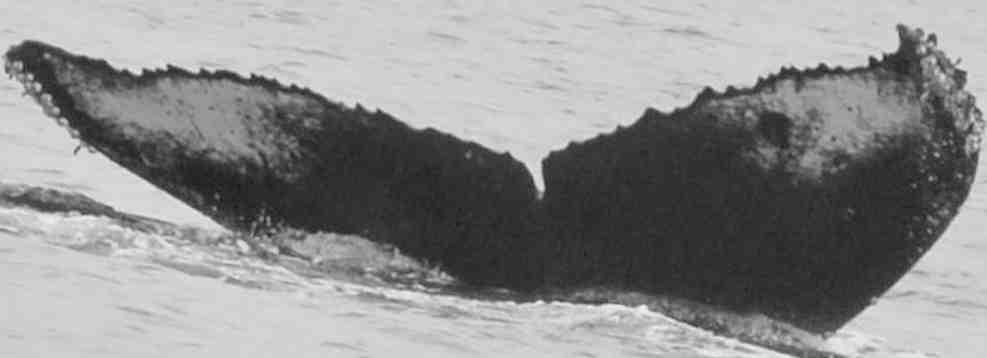
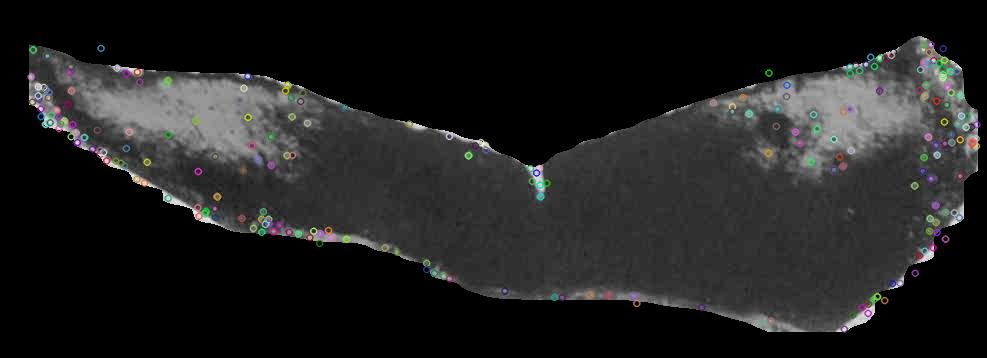
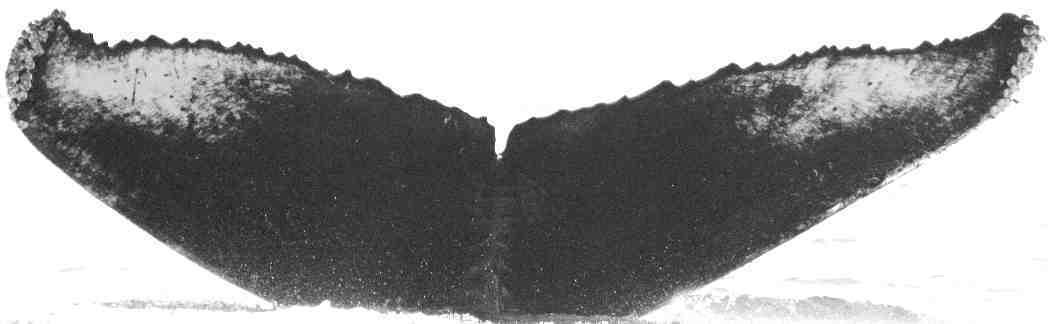
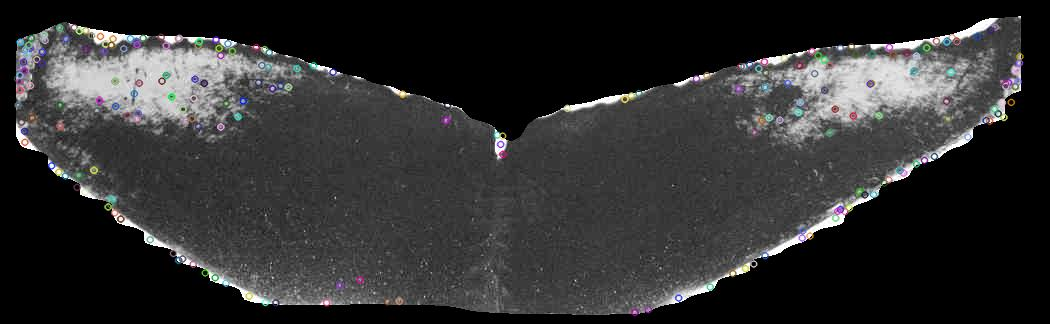
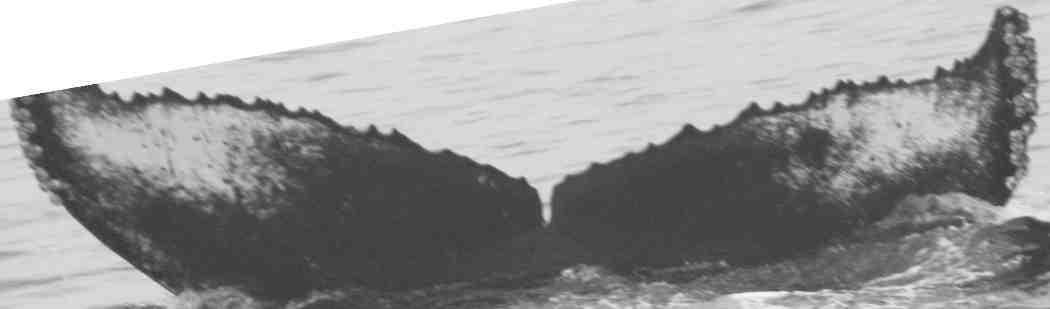
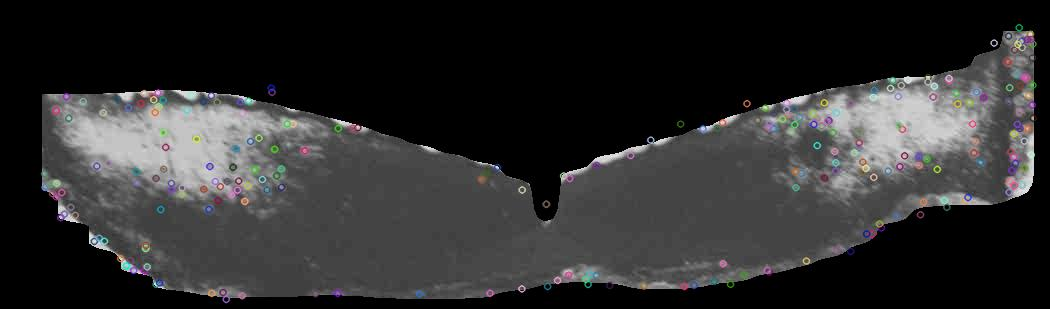
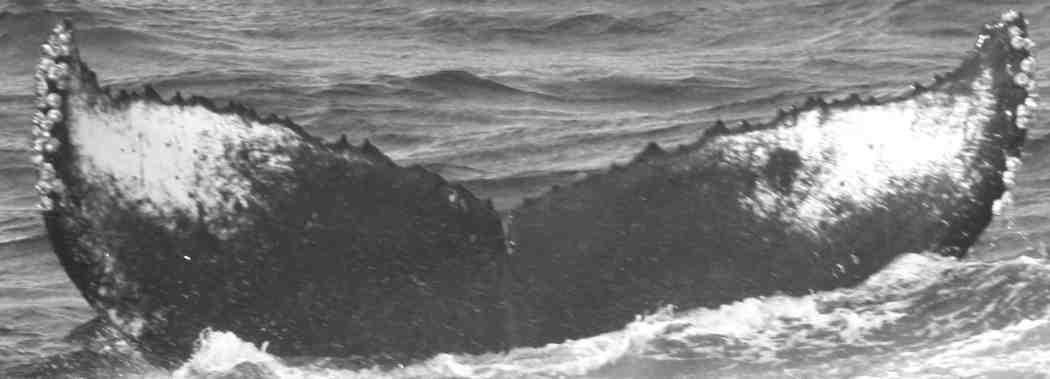
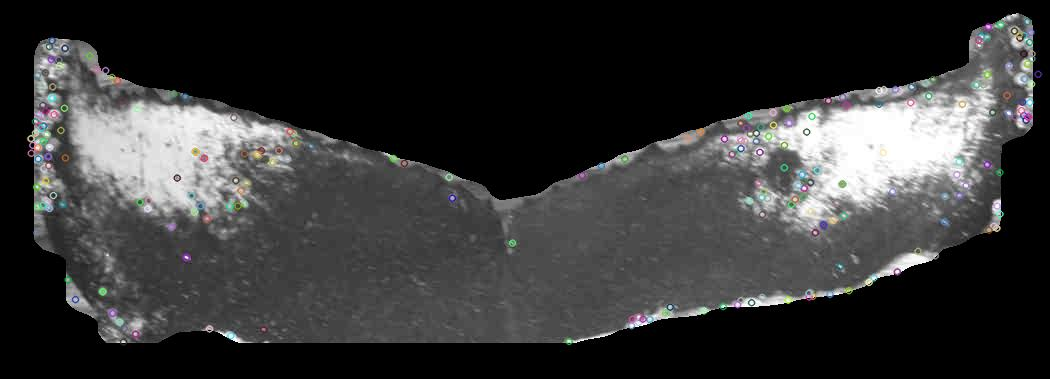
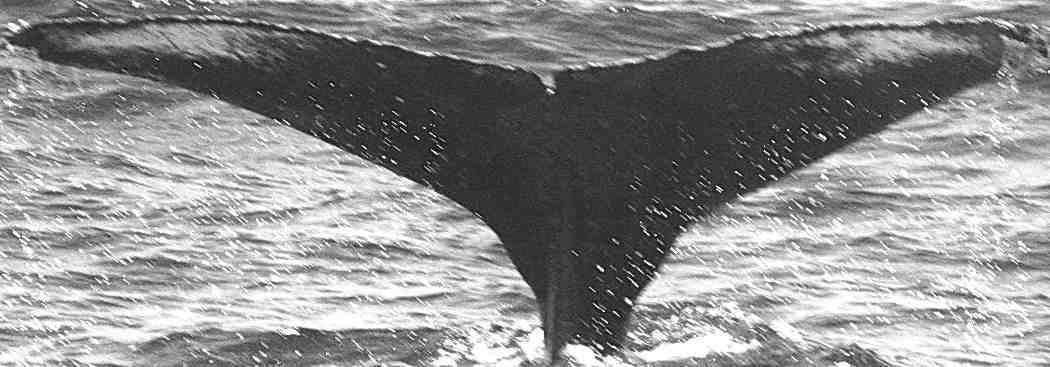
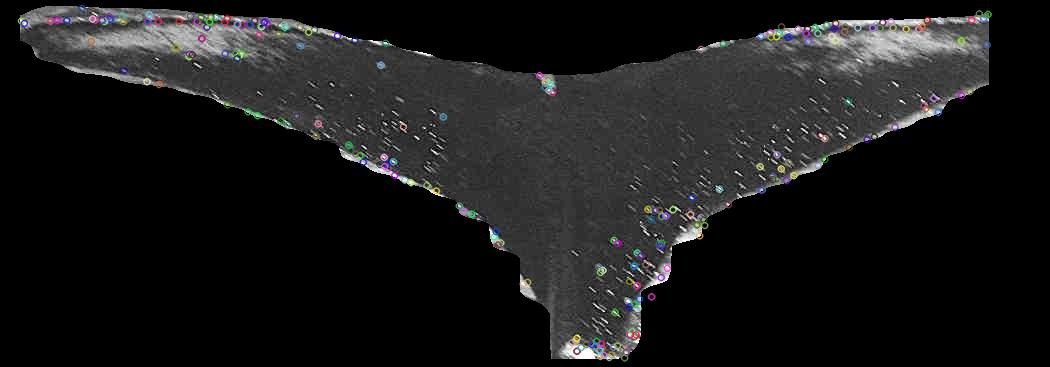
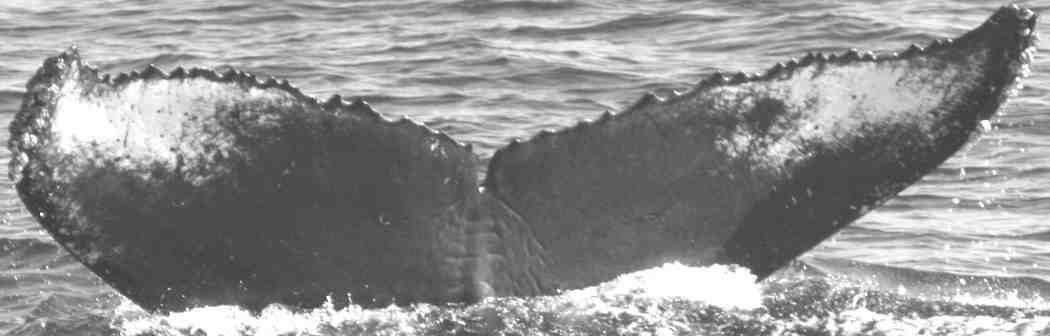
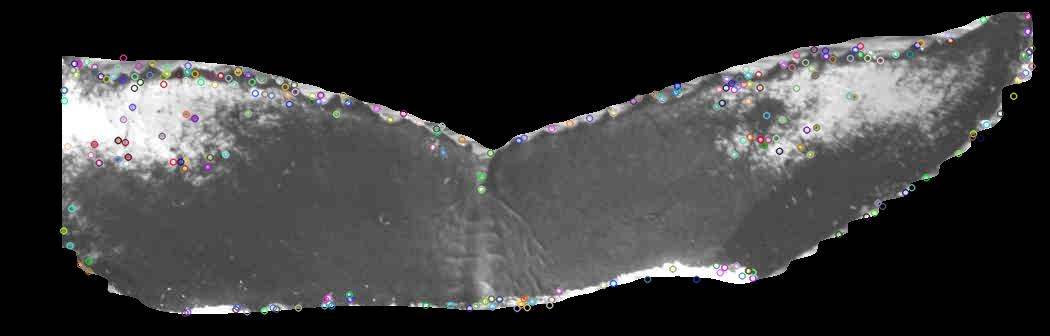
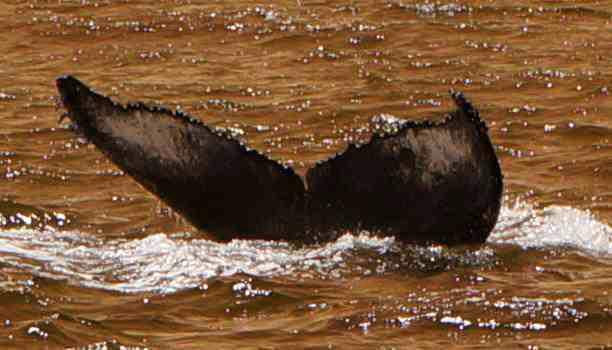
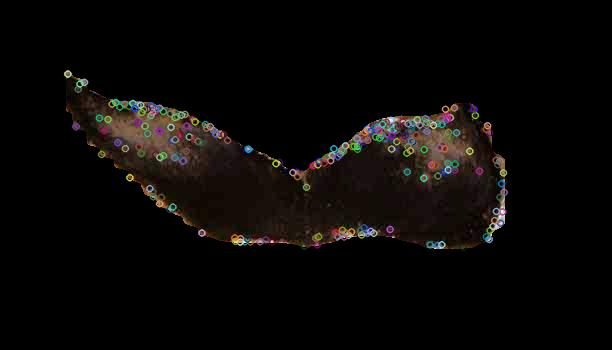
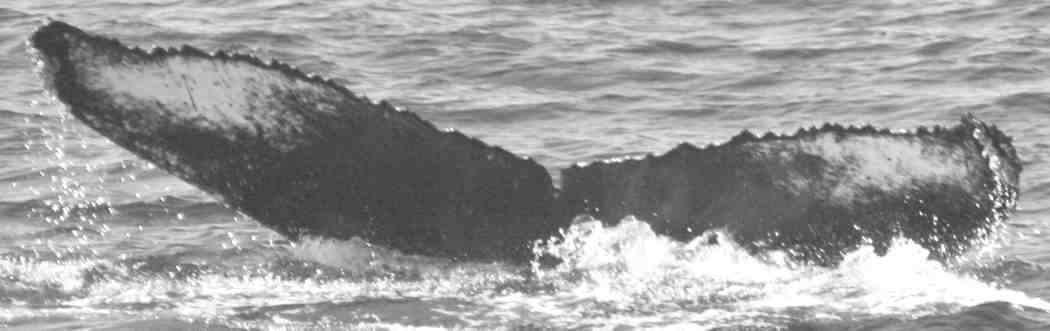
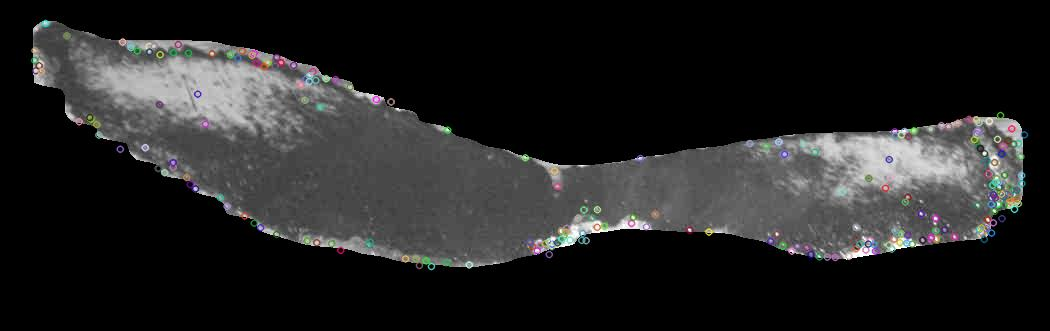
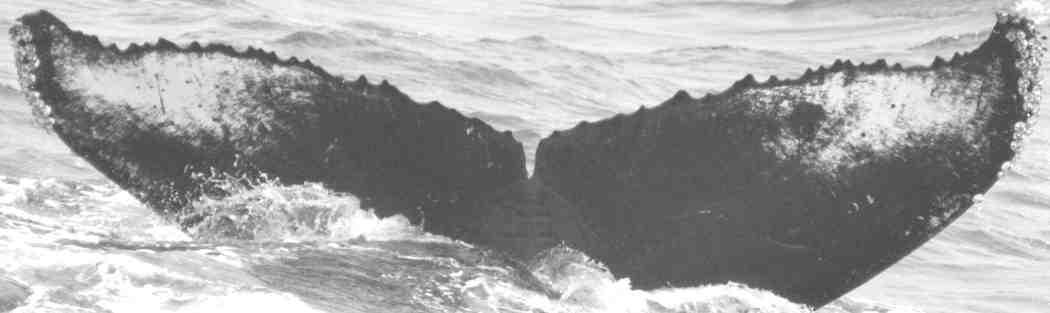
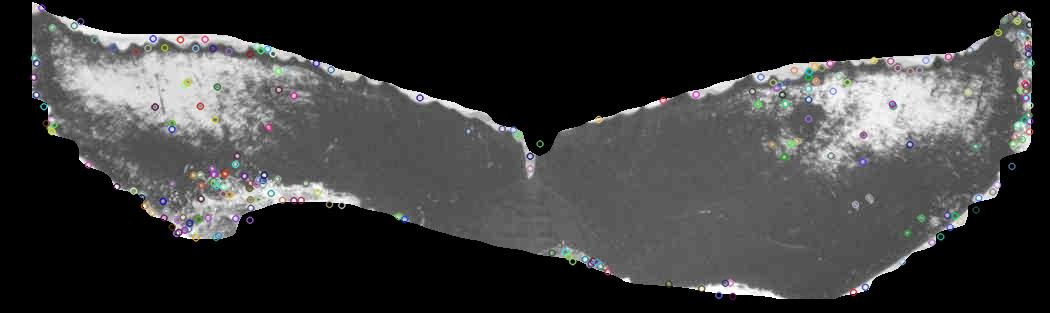
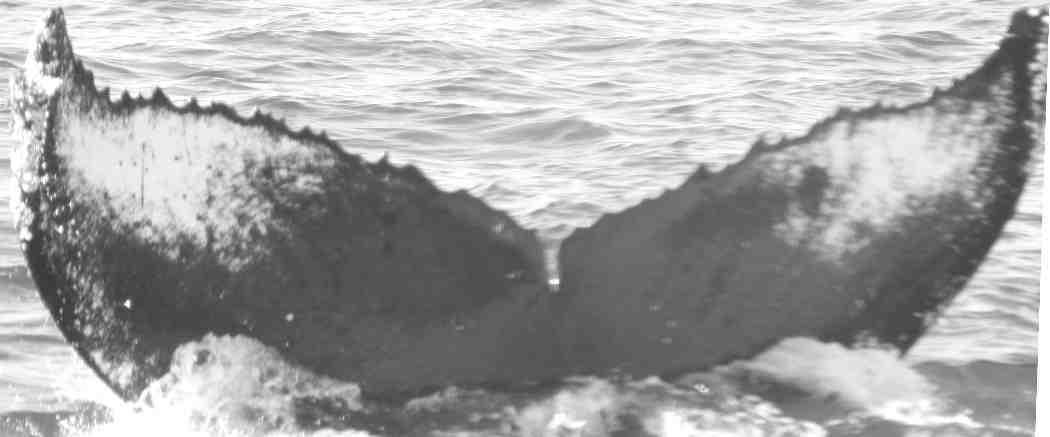
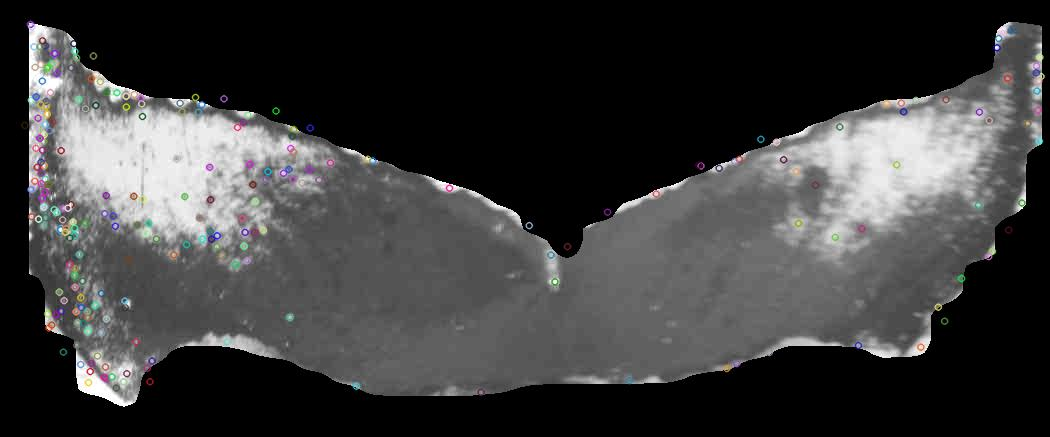
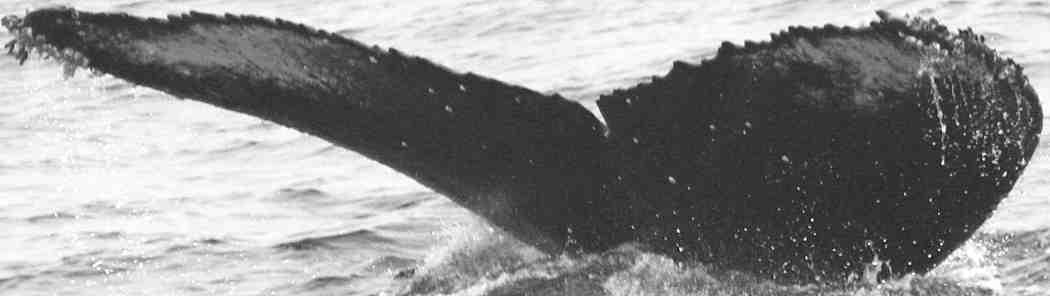
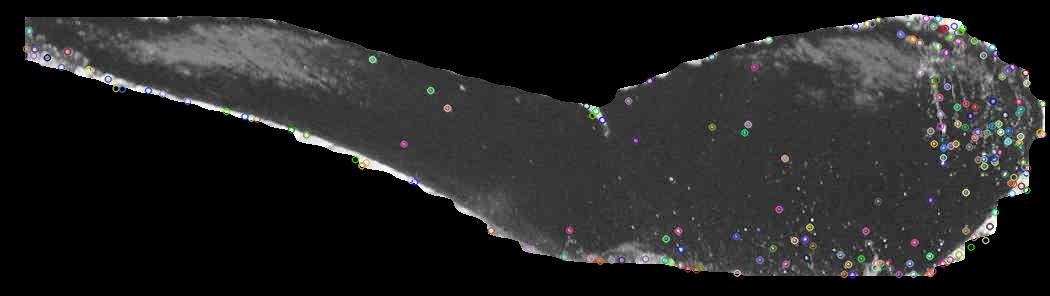
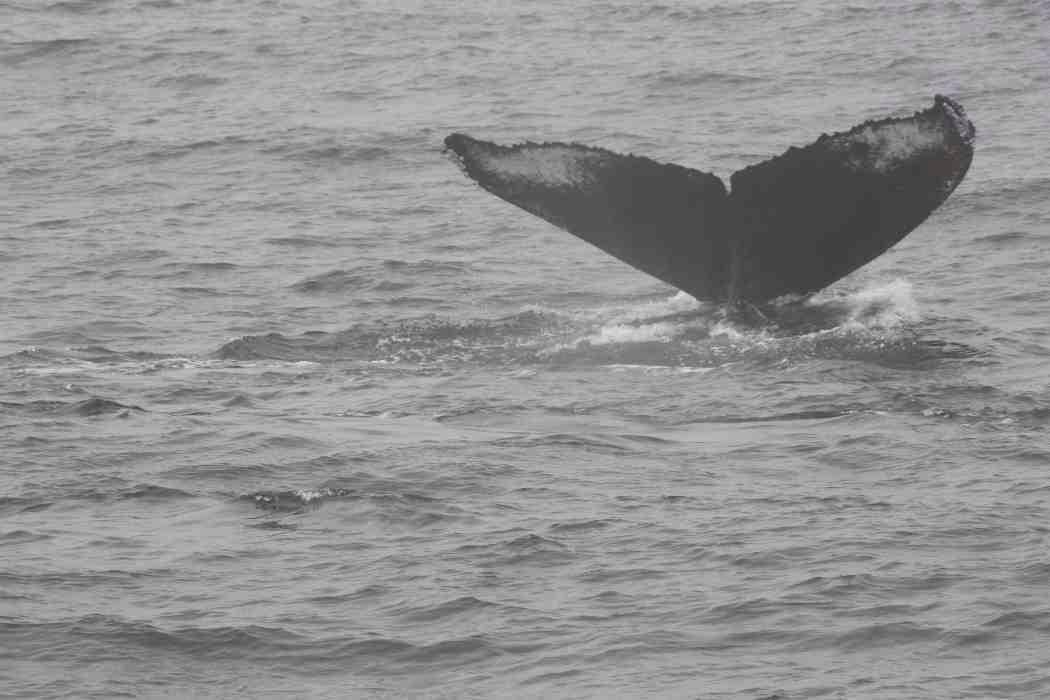
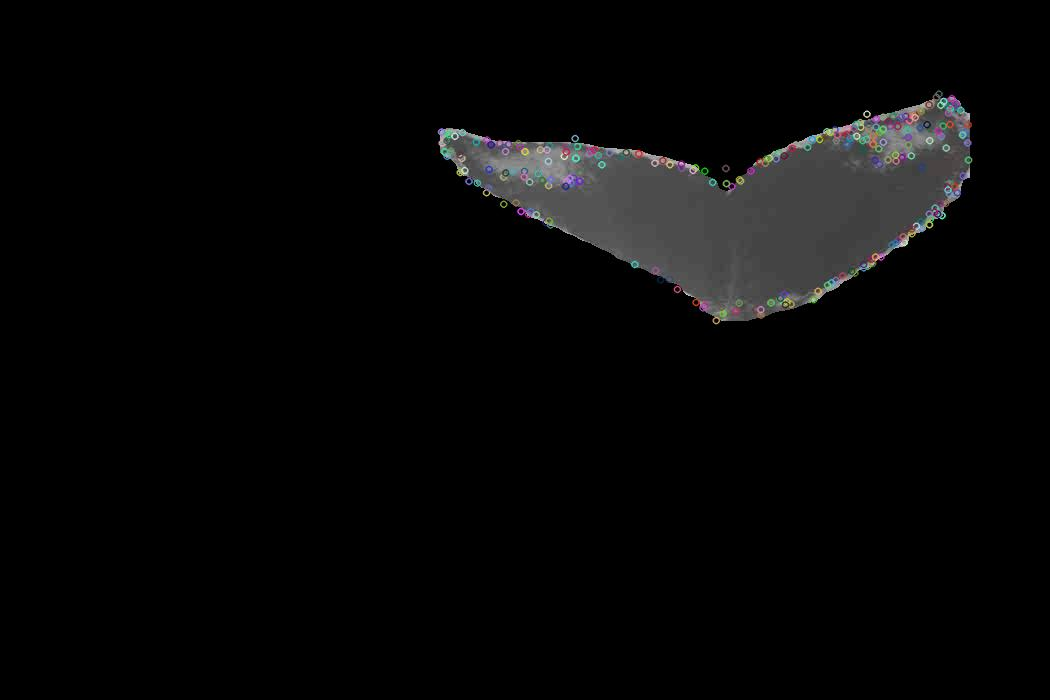
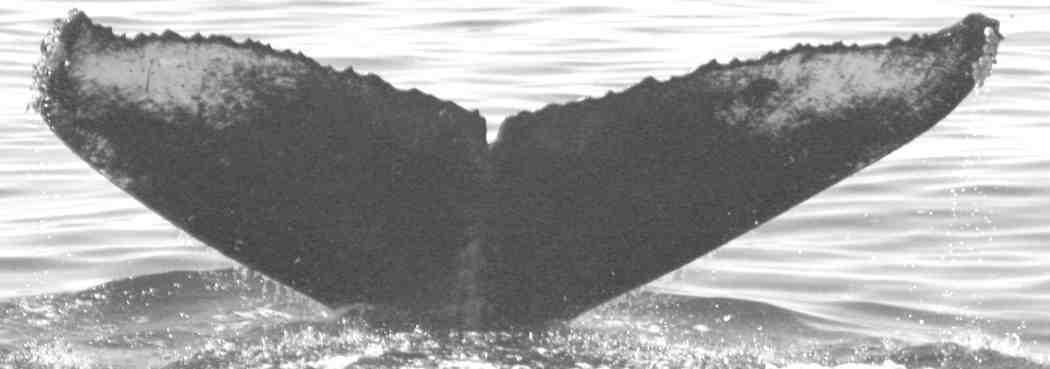
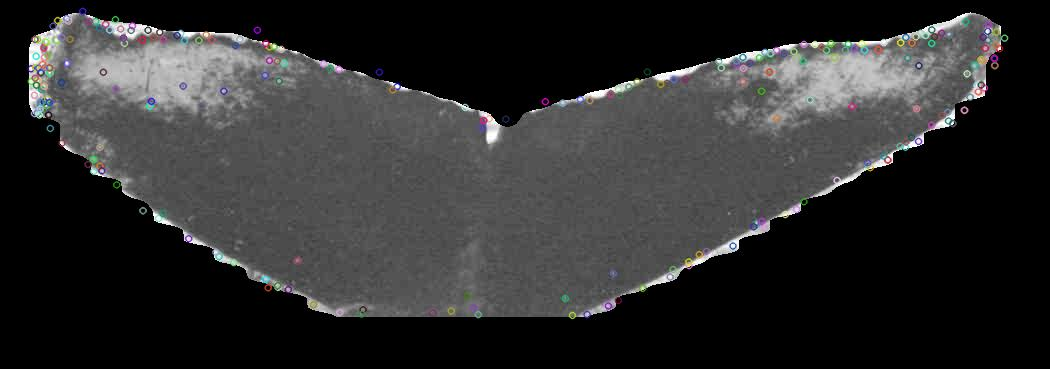
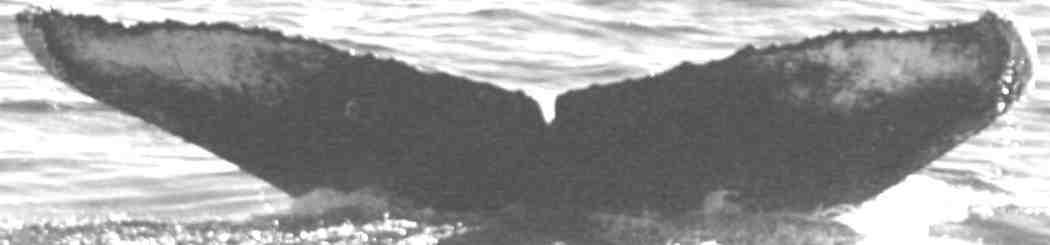
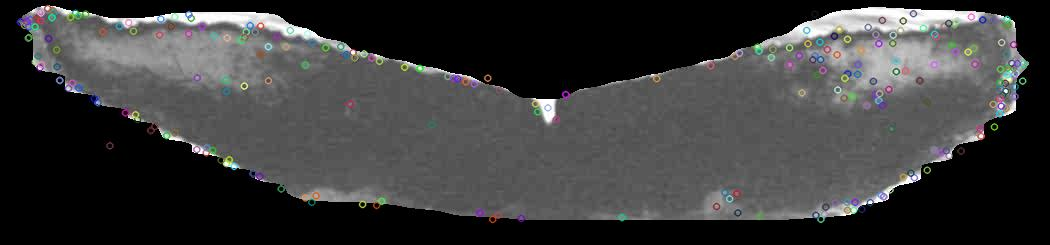
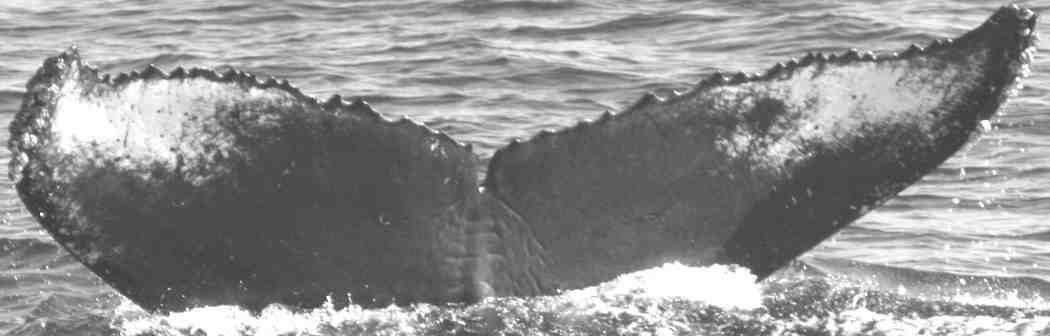
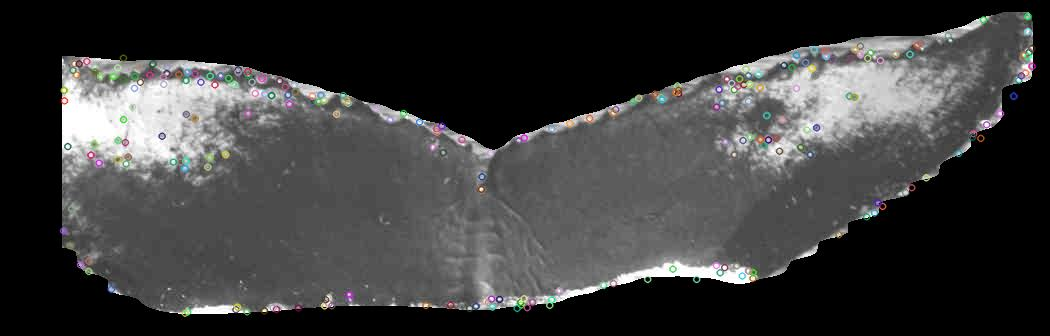
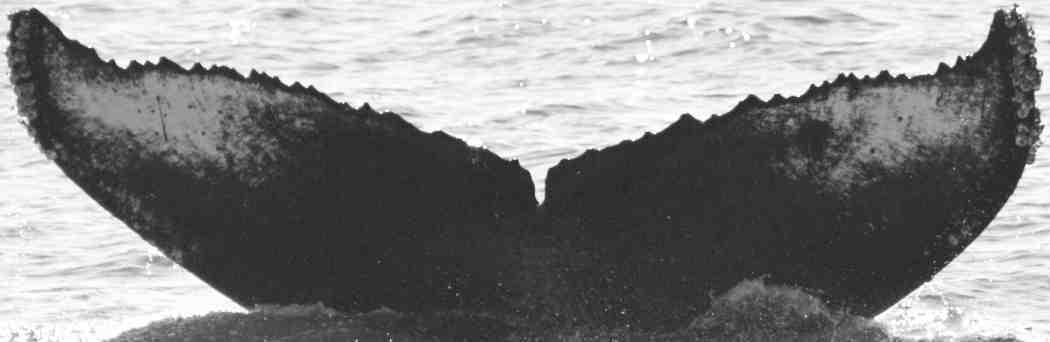
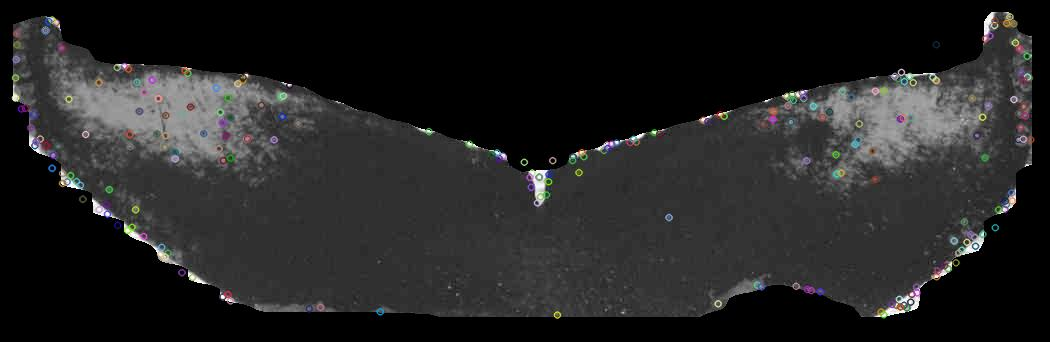
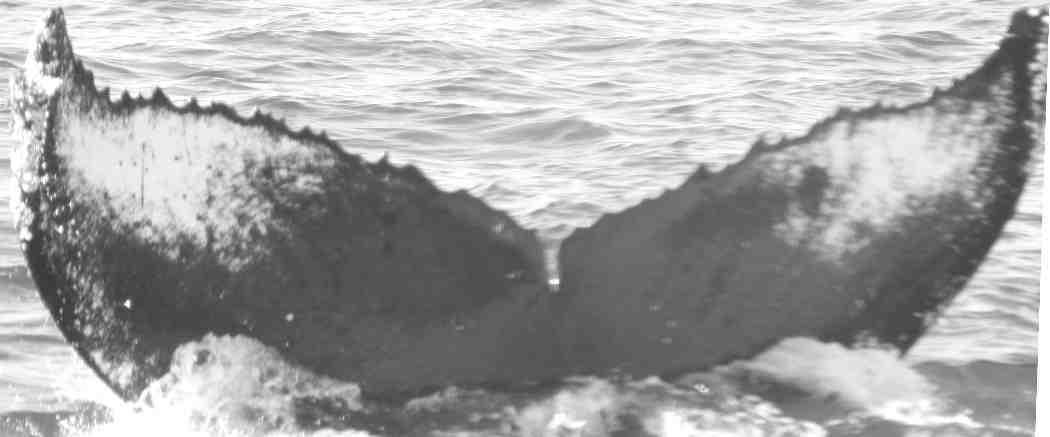
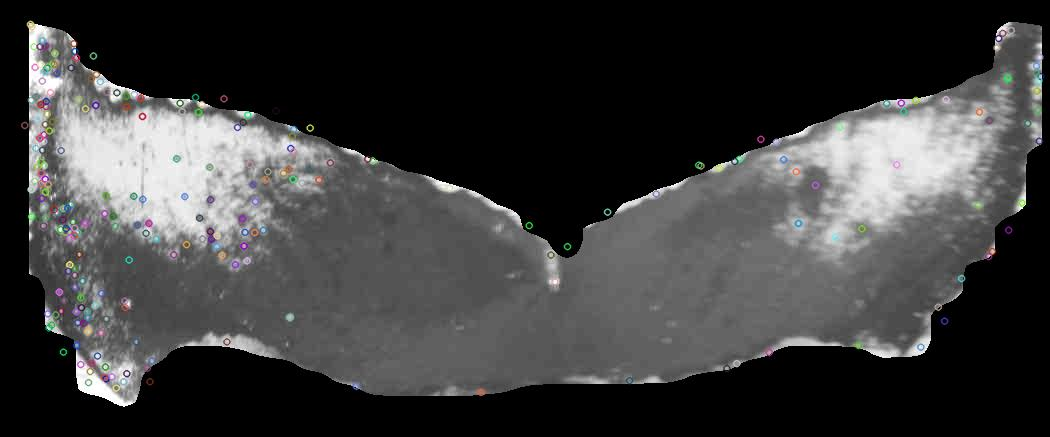
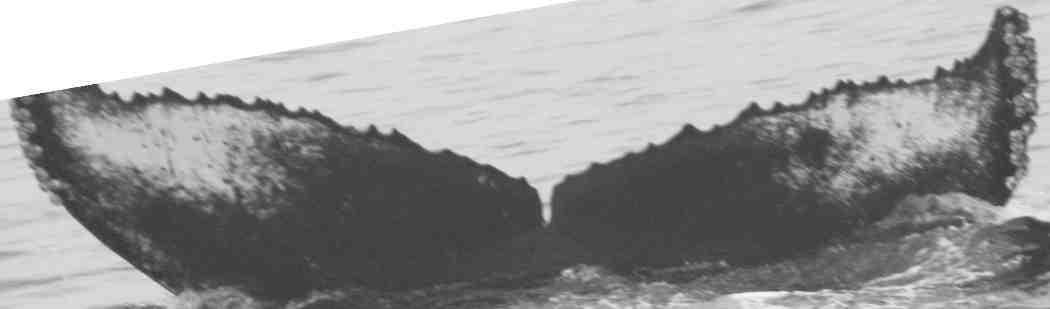
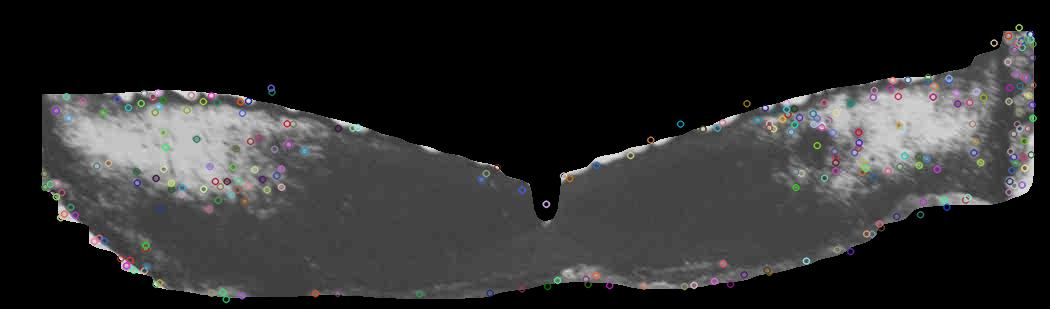

In [50]:
HTML(td[['file', 'fimg', 'sifted']].to_html(formatters={'fimg': image_formatter, 'sifted':image_formatter}, escape=False))